# Análisis Exploratorio de Datos (*EDA*, por sus siglas en inglés)

## Inicialización del código: importaciones de librerías y definición de variables generales

In [1]:
# Se conecta con la unidad de drive
#from google.colab import drive
# drive.mount('/content/drive')


In [2]:
#!pip install imblearn

In [3]:
#Se importan las librerías necesarias más generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
from pathlib import Path
import math
import random
import json
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

Se inicializan estilos, semillas y variables de ruta

In [4]:
# Se fija una semilla para los procesos estocásticos
seed = 42
random.seed(seed)
np.random.seed(seed)
plt.style.use("seaborn-v0_8-pastel")
colors = ['#00FF0080', '#0000FF80', '#FF000080', '#87CEEB80'] # Verde, azul, rojo y celeste con 50% de transparencia
personal_cmap = ListedColormap(colors)
# Se inicializa una variable con la ruta actual donde leer y guardar documentos
#BASE_FOLDER = Path('/content/drive/MyDrive/6- Master Universitario en Big Data y Ciencias de Datos/2- Asignaturas/12. TFM - Deteccion de fraude en movimientos transaccionales con Deep Learning/2. Entregable/code')
BASE_FOLDER = Path.cwd()
# Se define el nombre del modelo del archivo completo
version = 'v7'

## Carga, descripción y transformación del Dataset

### Carga e inspección visual

In [5]:
# Se importa el dataset con los datos
df = pd.read_csv(BASE_FOLDER / 'data' / 'Base.csv')
# Se cambia la ruta del base_folder según la versión
BASE_FOLDER = Path(BASE_FOLDER / version)
# Se muestran las primeras 5 instancias para una rápida visualización
df.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ...                0   
1               -0.849551           AD          1658  ...                0   
2               -1.490386           AB          1095  ...                0   
3               -1.863101           AB          3483  ...                0   
4               47.152498           AA          2339  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  16.224843     linux                   1   
1                   3.363854     other                   1   
2                  22.730559   windows                   0   
3                  15.215816     linux                   1   
4                   3.743048     other                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      0  
1                          1                  0      0  
2                          1                  0      0  
3                          1                  0      0  
4                          1                  0      0  

[5 rows x 32 columns]

In [6]:
# Se imprime información general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

En este dataset se tiene un dataset de 1 millón de instancias. Cada instancia (fila) del conjunto de datos representa una solicitud individual realizada vía online. La etiqueta de cada instancia se encuentra en la columna "fraud_bool". Una instancia positiva representa un intento fraudulento, mientras que una instancia negativa representa una solicitud legítima (Jesus et al., s. f.).

Además, se tienen 32 características distintas, de las cuales:
- 4 son categóricas
- 7 son binarias
- 21 son numéricas

Debido a que la detección de fraudes bancarios se trata de un problema desbalanceado, se genera una primera observación del ratio de desbalanceo. Para ello, se visualiza el porcentaje de datos de la clase 0 (transacción legítima) y de la clase 1 (transacción fraudulenta) de la característica "fraud_bool".

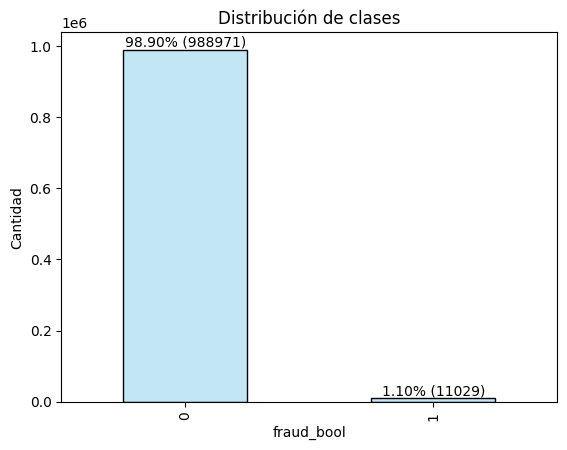

In [7]:
# Generar la gráfica
ax = df['fraud_bool'].value_counts().plot.bar(color = colors[3], edgecolor = 'black')
counts, perc = df['fraud_bool'].value_counts(), df['fraud_bool'].value_counts(normalize = True)
# Mostrar los valores porcentuales en las barras
for idx, valor in enumerate(counts):
    ax.text(idx, valor, f"{perc[idx]:.2%} ({valor})", ha='center', va='bottom')

ax.set_ylabel("Cantidad")
ax.set_title("Distribución de clases")

plt.show()

Claramente, se trata de un problema extremadamente desbalanceado, por lo que probablemente se deban aplicar técnicas de balanceo de datos para poder obtener buenas métricas al aplicar los modelos de *deep learning*.

### Descripción del Dataset

Cada instancia es una solicitud de cuenta bancaria sintética con ingeniería de características que incluye los siguientes campos (Jesus et al., s. f.):  

- **income (numérico)**: Ingreso anual del solicitante (en forma de decil). Rango entre [0.1, 0.9].  
- **name_email_similarity (numérico)**: Métrica de similitud entre el correo electrónico y el nombre del solicitante. Valores más altos indican mayor similitud. Rango entre [0, 1].  
- **prev_address_months_count (numérico)**: Número de meses en la dirección registrada anterior del solicitante, es decir, su residencia previa, si aplica. Rango entre [−1, 380] meses (-1 indica un valor faltante).  
- **current_address_months_count (numérico)**: Número de meses en la dirección actual registrada del solicitante. Rango entre [−1, 429] meses (-1 indica un valor faltante).  
- **customer_age (numérico)**: Edad del solicitante en años, redondeada a la década. Rango entre [10, 90] años.  
- **days_since_request (numérico)**: Número de días transcurridos desde que se realizó la solicitud. Rango entre [0, 79] días.  
- **intended_balcon_amount (numérico)**: Monto inicial transferido para la solicitud. Rango entre [−16, 114] (valores negativos indican valores faltantes).  
- **payment_type (categórico)**: Tipo de plan de pago con crédito. 5 valores posibles (anonimizados).  
- **zip_count_4w (numérico)**: Número de solicitudes dentro del mismo código postal en las últimas 4 semanas. Rango entre [1, 6830].  
- **velocity_6h (numérico)**: Velocidad total de solicitudes realizadas en las últimas 6 horas, es decir, el número promedio de solicitudes por hora en ese período. Rango entre [−175, 16818].  
- **velocity_24h (numérico)**: Velocidad total de solicitudes realizadas en las últimas 24 horas, es decir, el número promedio de solicitudes por hora en ese período. Rango entre [1297, 9586].  
- **velocity_4w (numérico)**: Velocidad total de solicitudes realizadas en las últimas 4 semanas, es decir, el número promedio de solicitudes por hora en ese período. Rango entre [2825, 7020].  
- **bank_branch_count_8w (numérico)**: Número total de solicitudes en la sucursal bancaria seleccionada en las últimas 8 semanas. Rango entre [0, 2404].  
- **date_of_birth_distinct_emails_4w (numérico)**: Número de correos electrónicos asociados a solicitantes con la misma fecha de nacimiento en las últimas 4 semanas. Rango entre [0, 39].  
- **employment_status (categórico)**: Estado laboral del solicitante. 7 valores posibles (anonimizados).  
- **credit_risk_score (numérico)**: Puntuación interna de riesgo de la solicitud. Rango entre [−191, 389].  
- **email_is_free (binario)**: Tipo de dominio del correo electrónico de la solicitud (ya sea gratuito o de pago).  
- **housing_status (categórico)**: Estado de residencia actual del solicitante. 7 valores posibles (anonimizados).  
- **phone_home_valid (binario)**: Validez del número de teléfono fijo proporcionado.  
- **phone_mobile_valid (binario)**: Validez del número de teléfono móvil proporcionado.  
- **bank_months_count (numérico)**: Antigüedad en meses de la cuenta bancaria previa (si se posee). Rango entre [−1, 32] meses (-1 indica un valor faltante).  
- **has_other_cards (binario)**: Indica si el solicitante posee otras tarjetas de la misma entidad bancaria.  
- **proposed_credit_limit (numérico)**: Límite de crédito propuesto por el solicitante. Rango entre [200, 2000].  
- **foreign_request (binario)**: Indica si el país de origen de la solicitud es diferente del país del banco.  
- **source (categórico)**: Fuente en línea de la solicitud. Puede ser navegador web (INTERNET) o aplicación móvil (TELEAPP).  
- **session_length_in_minutes (numérico)**: Duración de la sesión del usuario en la web bancaria en minutos. Rango entre [−1, 107] minutos (-1 indica un valor faltante).  
- **device_os (categórico)**: Sistema operativo del dispositivo que realizó la solicitud. Valores posibles: Windows, macOS, Linux, X11 u otro.  
- **keep_alive_session (binario)**: Opción del usuario sobre el cierre de sesión.  
- **device_distinct_emails (numérico)**: Número de correos electrónicos distintos utilizados en la web bancaria desde el mismo dispositivo en las últimas 8 semanas. Rango entre [−1, 2] (-1 indica un valor faltante).  
- **device_fraud_count (numérico)**: Número de solicitudes fraudulentas realizadas desde el mismo dispositivo. Rango entre [0, 1].  
- **month (numérico)**: Mes en el que se realizó la solicitud. Rango entre [0, 7].  
- **fraud_bool (binario)**: Indica si la solicitud es fraudulenta o no.

[Traducción propia]

### Tratamiento de valores faltantes

Una vez descritas todas las variables intervinientes, se observa que en la información general del dataset no se diferencian por el tipo de datos los numéricos de los binarios. Sin embargo, es importante diferenciarlos ya que se va a aplicar un tratamiento distinto a cada tipo.

Para ello, se crea un diccionario con cada variable y el tipo de esta de acuerdo con la descripción.

In [8]:
variables_dict = {
    "income": "numeric",
    "name_email_similarity": "numeric",
    "prev_address_months_count": "numeric",
    "current_address_months_count": "numeric",
    "customer_age": "numeric",
    "days_since_request": "numeric",
    "intended_balcon_amount": "numeric",
    "payment_type": "categorical",
    "zip_count_4w": "numeric",
    "velocity_6h": "numeric",
    "velocity_24h": "numeric",
    "velocity_4w": "numeric",
    "bank_branch_count_8w": "numeric",
    "date_of_birth_distinct_emails_4w": "numeric",
    "employment_status": "categorical",
    "credit_risk_score": "numeric",
    "email_is_free": "binary",
    "housing_status": "categorical",
    "phone_home_valid": "binary",
    "phone_mobile_valid": "binary",
    "bank_months_count": "numeric",
    "has_other_cards": "binary",
    "proposed_credit_limit": "numeric",
    "foreign_request": "binary",
    "source": "categorical",
    "session_length_in_minutes": "numeric",
    "device_os": "categorical",
    "keep_alive_session": "binary",
    "device_distinct_emails_8w": "numeric",
    "device_fraud_count": "numeric",
    "month": "numeric",
    "fraud_bool": "binary"
}

# Definir las columnas numéricas y categóricas o binarias
numerical_features = [col for col in df.columns if variables_dict[col] == 'numeric']
categorical_features = [col for col in df.columns if variables_dict[col] == 'categorical']
binary_features = [col for col in df.columns if variables_dict[col] == 'binary']

A continuación, se crea una función que realizará una transformación a los datos faltantes (negativos) en función del tipo de variable.

La estrategia que se lleva a cabo es la siguiente:
- Variables numéricas: se transforman todos los valores negativos en ceros. Esto es importante ya que, en futuros pasos, se normalizarán los datos. Al normalizar, si una variable con rangos, por ejemplo, entre 400 y 1600, tiene un valor negativo como -200, este último modificará drásticamente el comportamiento de la normalización de la variable. Sin embargo, tampoco es conveniente que los valores "faltantes" se conviertan en valores habituales (haciendo transformaciones habituales como la media o la mediana), ya que la ausencia de datos puede ser una pista crucial para identificar transacciones fraudulentas. Por lo tanto, se transforman a 0 y esto marcaría siempre el valor más bajo (en caso de que hayan valores faltantes para esa variable) en la normalización.
- Variables binarias o categóricas: se transforman todos los valores negativos a la clase menos representada. Por el mismo motivo que expuesto anteriormente, no conviene convertirlos en la clase más representada para no perder pistas importantes.



In [9]:
def transform_na_values(df, col):
  '''
  Realiza una transformación de los valores faltantes en función del tipo de
  columna.
  '''
  type_col = variables_dict[col]
  if type_col == 'numeric':
    #Se obtienen todos los datos disponibles de la columna
    #values_availables = df[df[col] >= 0][col]
    # Se escoge su mínimo
    #min_value = values_availables.min()
    # Se divide a la mitad y se hace entero
    #min_value = math.ceil(min_value / 10)
    # Se sustituye por los valores no disponibles
    df[col][df[col]<0] = 0
  elif type_col == 'binary' or type_col == 'categorical':
    # Se obtienen todos los datos disponibles de la columna
    values_availables = df[df[col] >= -1][col]
    # Se obtiene la frecuencia de cada valor único
    v_a_counts = values_availables.value_counts()
    # Se obtiene el valor que más se repite
    rare_value = v_a_counts.idxmin()
    # Se sustituye por los valores faltantes
    df[col][df[col]<0] = rare_value
  return df


Se ejecuta la función y se transforma el dataset eliminando los valores negativos.

In [10]:
# Se analizan las columnas que tienen algún valor negativo y se realiza un
#proceso de transformación en función del tipo de columna
def remove_negative_values(df):
  total = len(df)
  for col in df.columns:
      try:
        qty_nulls = len(df[df[col] < 0])
        perc_nulls = round(qty_nulls / total, 4)
        print(f"% of nulls in {col}: {perc_nulls} %")
      except:
        perc_nulls = 0
      # Elimino las instancias que tienen un -1 para evitar instancias que no aportan al 100%
      if perc_nulls > 0:
        df = transform_na_values(df, col)
        print(f"nulls in col {col} transformed")
  return df

df = remove_negative_values(df)


% of nulls in fraud_bool: 0.0 %
% of nulls in income: 0.0 %
% of nulls in name_email_similarity: 0.0 %
% of nulls in prev_address_months_count: 0.7129 %
nulls in col prev_address_months_count transformed
% of nulls in current_address_months_count: 0.0043 %
nulls in col current_address_months_count transformed
% of nulls in customer_age: 0.0 %
% of nulls in days_since_request: 0.0 %
% of nulls in intended_balcon_amount: 0.7425 %
nulls in col intended_balcon_amount transformed
% of nulls in zip_count_4w: 0.0 %
% of nulls in velocity_6h: 0.0 %
% of nulls in velocity_24h: 0.0 %
% of nulls in velocity_4w: 0.0 %
% of nulls in bank_branch_count_8w: 0.0 %
% of nulls in date_of_birth_distinct_emails_4w: 0.0 %
% of nulls in credit_risk_score: 0.0144 %
nulls in col credit_risk_score transformed
% of nulls in email_is_free: 0.0 %
% of nulls in phone_home_valid: 0.0 %
% of nulls in phone_mobile_valid: 0.0 %
% of nulls in bank_months_count: 0.2536 %
nulls in col bank_months_count transformed
% of nu

C:\Users\Cristian\AppData\Local\Temp\ipykernel_32060\2838181776.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][df[col]<0] = 0
C:\Users\Cristian\AppData\Local\Temp\ipykernel_32060\2838181776.py:15: SettingWithCopyWarning: 
A val

### Visualización de Estimaciones de Densidad por Núcleo (KDE) en variables numéricas diferenciada por clase

C:\Users\Cristian\AppData\Local\Temp\ipykernel_32060\2372056653.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue=df['fraud_bool'], fill=True,  # Rellena el área bajo la curva


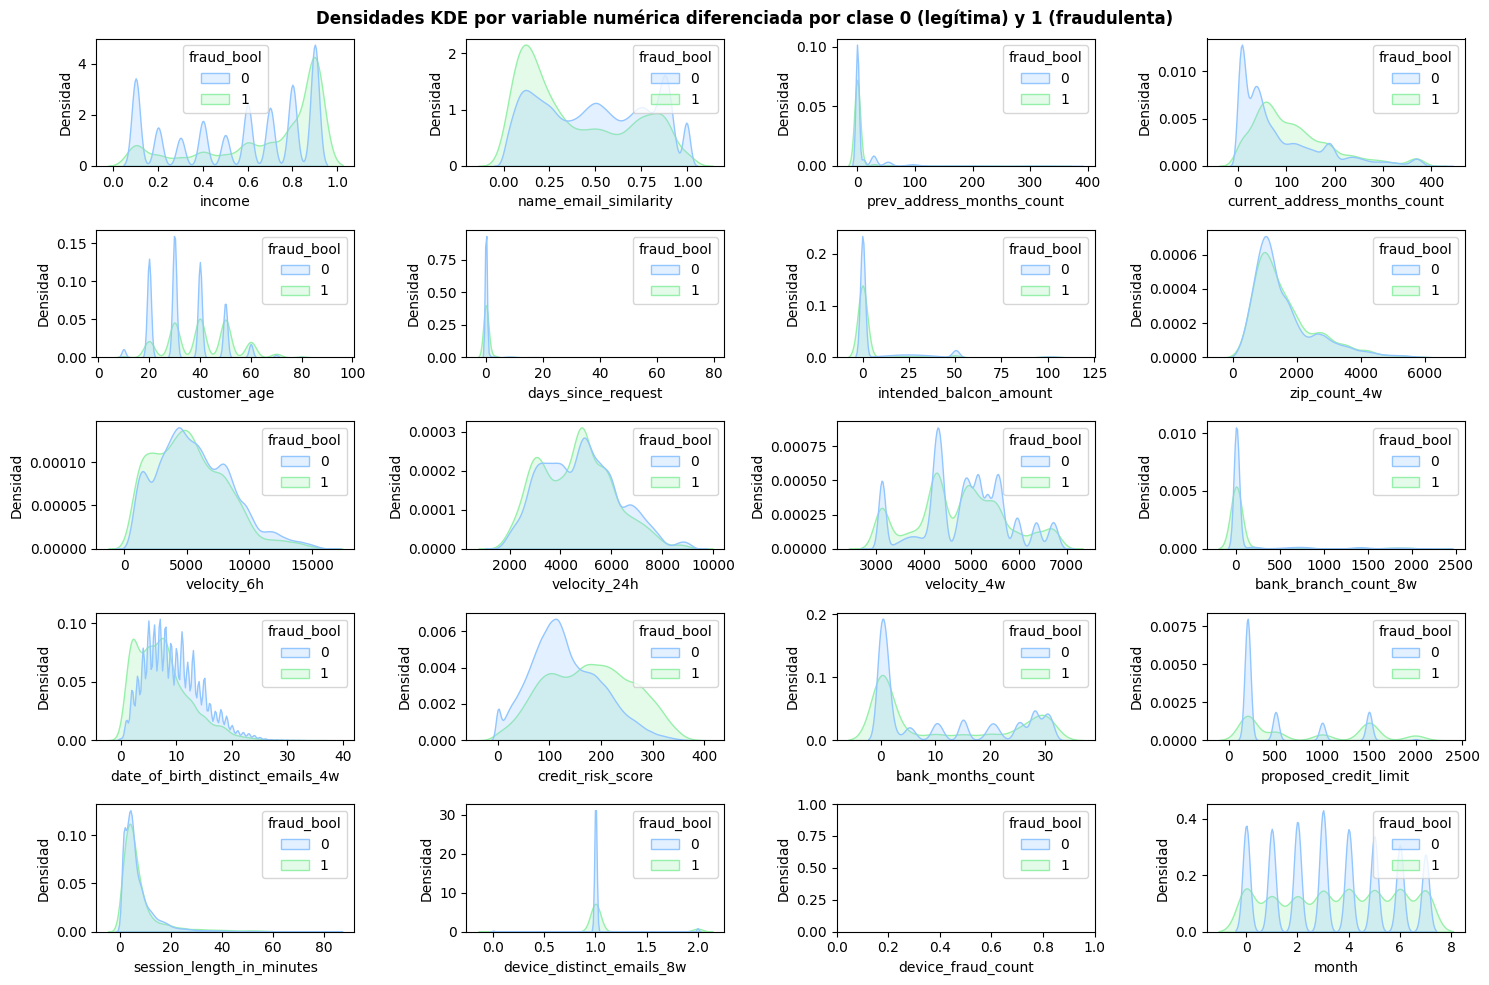

In [11]:
# Iterar sobre cada variable numérica para graficar la densidad KDE diferenciada por clase
fig, axs = plt.subplots(5, 4, figsize = (15, 10))
axs = axs.flatten()
for i, col in enumerate(numerical_features):     
    # Usamos kdeplot para generar la gráfica, diferenciando por la variable explicativa
    sns.kdeplot(data=df, x=col, hue=df['fraud_bool'], fill=True,  # Rellena el área bajo la curva
        common_norm=False,  # Para que cada clase se normalice de forma independiente
        ax = axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Densidad')

fig.suptitle(f'Densidades KDE por variable numérica diferenciada por clase 0 (legítima) y 1 (fraudulenta)', 
             fontweight = 'bold')
fig.tight_layout()
plt.show()

Estas gráficas muestran la distribución de diferentes variables numéricas en función de la clase de fraude (fraud_bool = 0 o 1). Algunas observaciones clave:

- Solapamiento entre clases: En la mayoría de las variables, las distribuciones de transacciones legítimas (azul) y fraudulentas (verde) se superponen considerablemente, lo que indica que no hay un único umbral claro para separar las clases.
- Algunas variables como *name_email_similarity* y *credit_risk_score* muestran diferencias en la distribución entre clases, sugiriendo que podrían aportar información valiosa para la clasificación.
Otras variables, como *session_length_in_minutes* o *customer_age*, parecen tener una distribución muy similar entre ambas clases, lo que sugiere que podrían tener menor relevancia predictiva.
Distribuciones multimodales: Algunas variables muestran múltiples picos en su distribución (por ejemplo, *velocity_6h*, *velocity_24h*), lo que sugiere que ciertos patrones de comportamiento podrían ser útiles para identificar fraude.
- Valores extremos y colas largas: Variables como *proposed_credit_limit* y *zip_count_4w* presentan valores extremos que pueden influir en la clasificación. Modelos más avanzados como redes neuronales pueden manejar mejor estos casos que modelos lineales.
- La variable *device_fraud_count* no presenta distribución alguna. Esto es debido a que todas las instancias de la variable contienen el mismo valor y, por lo tanto, se puede eliminar del dataset debido a que no aporta valor.


In [12]:
df.drop('device_fraud_count', axis = 1, inplace = True)
numerical_features.remove('device_fraud_count')

### Visualización de la matriz de correlaciones

Se preprocesa el archivo de entrada de forma que todos los parámetros seán numéricos, bien continuos o discretos (variables categóricas transformadas a través de One-hot encoding).

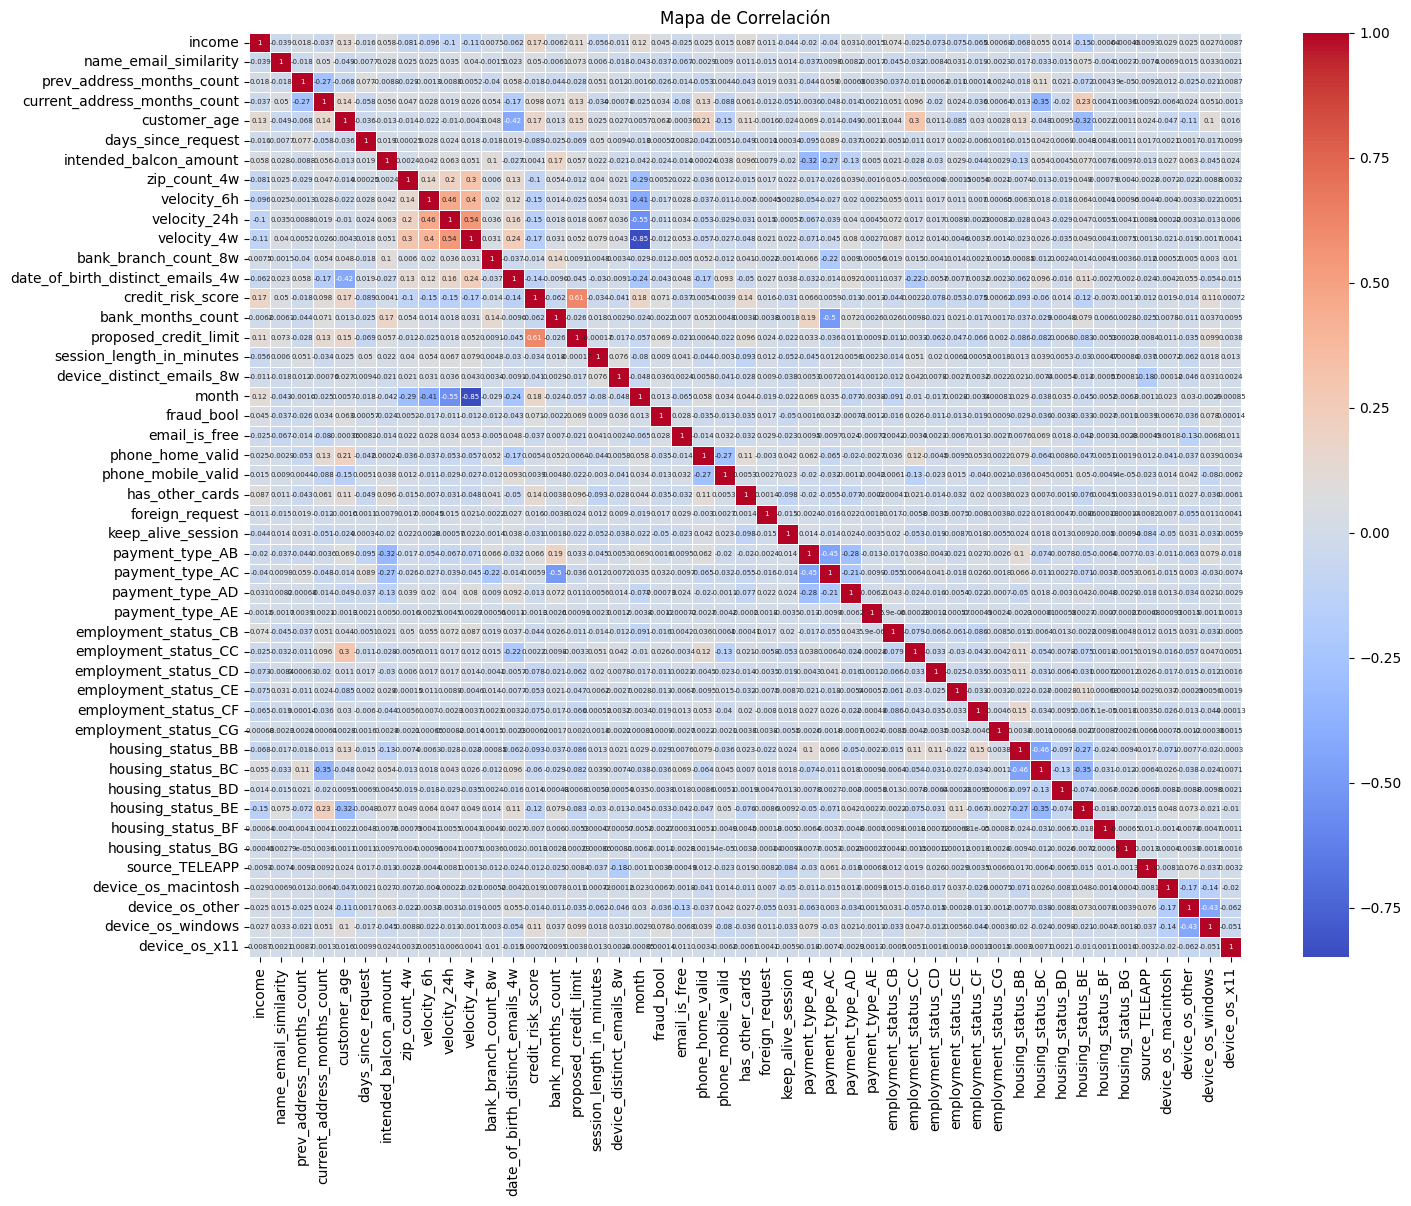

In [13]:
# Se reordenan las columnas para una mejor visualización de la m. de corr
cols_ordered = numerical_features + categorical_features + binary_features
df = df[cols_ordered]
#Realizo un OneHotEncoder para cada variable categórica
df_encoded = pd.get_dummies(df, columns = categorical_features, drop_first = True)
# Se crea la matriz de correlación
corr_matrix = df_encoded.corr()
# Se grafica la matriz de correlación
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",  linewidths=0.5, annot_kws={"size": 5})
plt.title("Mapa de Correlación")
plt.show()

Como se puede observar en la matriz, no existen variables altamente correlacionadas (coeficiente de Pearson mayor a 0.9). No obstante, existe una correlación moderadamente alta entre la variable *month* y *velocity_4w*. Sin embargo, debido a que la columna *month* se usará para dividir el dataset en próximos pasos, será eliminada del entrenamiento y esta correlación quedará mitigada.

Por otra parte, no existe ninguna variable que esté altamente correlacionada con fraud_bool, por lo que se puede inferir que las características no lineales o interacciones complejas entre variables podrían ser más relevantes para la clasificación del fraude, y el modelo probablemente necesitará explorar relaciones más complejas para identificar patrones en los datos.

### División entrenamiento y validación

De acuerdo con la publicación adjunta al dataset (Jesus et al., s. f., Question 11), se recomienda usar la columna *month* para dividir los datos de entrenamiento y test. Además, en dicha publicación se explica que cada instancia es independiente de cualquier otra sin que haya una secuencialidad que condicione los resultados en función del orden de las filas en la tabla.

Por lo tanto, se dividiran los datos de la siguiente manera:
- Entrenamiento: instancias anteriores al mes 6.
- Validación y Test: instancias posteriores al mes 6 inclusive.
  - Validación: 50% de los datos reservados para validación y test
  - Test: 50% de los datos reservados para validación y test

In [14]:
#Se dividen en datos de entrenamiento y validación
X_train, X_val, y_train, y_val = (df_encoded[df_encoded['month'] < 6].drop('fraud_bool', axis = 1),
                                  df_encoded[df_encoded['month'] >= 6].drop('fraud_bool', axis = 1),
                                  df_encoded['fraud_bool'][df_encoded['month'] < 6],
                                  df_encoded['fraud_bool'][df_encoded['month'] >= 6])

#Como se ha filtrado en función del mes, esto no puede ser un condicionante para el entrenamiento, por lo que se elimina la columna
X_train.drop('month', axis = 1, inplace = True)
X_val.drop('month', axis = 1, inplace = True)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = True, random_state = 42, stratify = y_val)

### Submuestreo

Hay dos motivos por los que realizar un submuestreo de las instancias:

- Limites de rendimiento computacional: actualmente se tiene 1 millón de instancias. Entrenar modelos de aprendizaje profundo con esta cantidad de datos requiere un costo computacional muy elevado.
- Reducir el desbalanceo: aunque se aplicarán otras técnicas más avanzadas de balanceo de datos, el submuestreo puede ser una herramienta fundamental para garantizar que los modelos no se sesguen hacia la clase predominante.

Por contra, esto puede afectar a los resultados al perder variabilidad de los datos originales.

Además, se deben de considerar dos aspectos muy importantes de esta operación:
- Con el fin de balancear, el submuestreo debe ejecutarse exclusivamente sobre la clase 0, *transacciones legítimas*, que es la clase mayoritaria.
- •	El submuestreo exclusivo de la clase 0, no debe aplicarse sobre los datos de validación y test. Estos grupos deben reducirse equitativamente en ambas clases. De lo contrario, generaría una distribución desequilibrada en la producción, lo que llevaría a obtener resultados poco realistas al evaluar los modelos en esos conjuntos.
- •	Si se submuestra los datos de entrenamiento con un ratio de reducción, se deben submuestrear con el mismo ratio los datos de validación y test (teniendo en cuenta el punto anterior). Si esto no se cumple, se podría obtener un gran desequilibrio entre los datos de entrenamiento y los datos de validación y test (los datos de entrenamiento deben representar una mayor parte, habitualmente, entre el 70% y el 80%).
- 
Por lo tanto, en primer lugar se crea una función de submuestreo que reduzca el número de muestras de cada clase en función del parámetro *label* que controlará si se reduce una sola clase o ambas. Además, recibirá como argumento los datos a reducir y el *factor*, que representa el porcentaje sobre el número total de instancias a eliminar sobre cada conjunto.

In [15]:
def subsampling(X, y, factor = 0.7, label = 2):
    '''
    Esta función reduce el número de muestras de la clase "label" según "factor".
    Si "label" == 2 (por defecto), se realizará el submuestreo de ambas clases.
    '''
    if label == 2:
        print("Realizando submuestreo de ambas clases...")
        # #Se extraen los índices no fraudulentos y fraudulentos de los datos de entrenamiento
        indexes_valid_data = X[y == 0].index.tolist()
        indexes_fraud_data = X[y == 1].index.tolist()
        # Se calculan las cantidades de instancias a eliminar de cada clase
        qty_valid_ind_to_remove = math.ceil(factor * len(indexes_valid_data))
        qty_fraud_ind_to_remove = math.ceil(factor * len(indexes_fraud_data))
        #Se escogen los índices por clase de forma aleatoria
        indexes_valid_to_remove = random.sample(indexes_valid_data, qty_valid_ind_to_remove)
        indexes_fraud_to_remove = random.sample(indexes_fraud_data, qty_fraud_ind_to_remove)
        # Se unen las listas de los índices
        indexes_to_remove = indexes_valid_to_remove + indexes_fraud_to_remove
    else:
        print(f"Realizando submuestreo de la clase {label}")
        # #Se extraen los índices no fraudulentos y fraudulentos de los datos de entrenamiento
        indexes = X[y == label].index.tolist()
        # Se calculan las cantidades de instancias a eliminar de cada clase
        qty_ind_to_remove = math.ceil(factor * len(indexes))
        #Se escogen los índices por clase de forma aleatoria
        indexes_to_remove = random.sample(indexes, qty_ind_to_remove)

    # Se eliminan del dataframe y se retornan las variables
    return X.drop(indexes_to_remove, axis = 0), y.drop(indexes_to_remove, axis = 0)

Se define el factor a 0.7 (eliminación del 70% de los datos) y se llama a la función con etiqueta de clase en el caso de entrenamiento (solo se eliminan instancias de la clase mayoritaria). Como ya se ha comentado, para los datos de validación y test se eliminan las filas de forma equitativa según el número de instancias de cada clase.

In [16]:
factor_to_remove = 0.7
X_train, y_train = subsampling(X_train, y_train, factor = factor_to_remove, label = 0)
X_val, y_val = subsampling(X_val, y_val, factor = factor_to_remove)
X_test, y_test = subsampling(X_test, y_test, factor = factor_to_remove)

Realizando submuestreo de la clase 0
Realizando submuestreo de ambas clases...
Realizando submuestreo de ambas clases...


Se muestra cómo quedan las distribuciones de los conjuntos de datos en función de la clase.

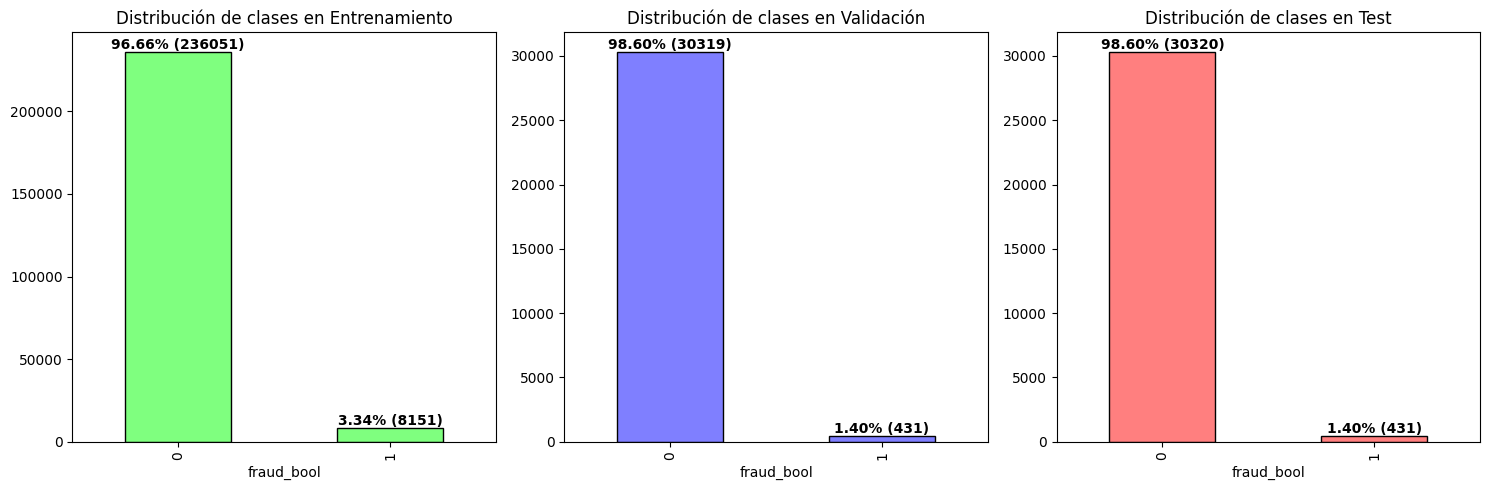

In [17]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Función para graficar y mostrar los porcentajes
def plot_class_distribution(y, ax, color, title):
    counts, perc = y.value_counts(), y.value_counts(normalize=True)
    counts.plot.bar(ax=ax, color = color, edgecolor = 'black')
    ax.set_title(title)
    for idx, valor in enumerate(counts):
        ax.text(idx, valor, f"{perc[idx]:.2%} ({valor})", ha='center', va='bottom', fontweight = 'bold')

# Graficar para el conjunto de entrenamiento
plot_class_distribution(y_train, axes[0], colors[0], 'Distribución de clases en Entrenamiento')

# Graficar para el conjunto de validación
plot_class_distribution(y_val, axes[1], colors[1], 'Distribución de clases en Validación')

# Graficar para el conjunto de test
plot_class_distribution(y_test, axes[2], colors[2], 'Distribución de clases en Test')

# Ajustar el layout para que no se solapen los títulos
plt.tight_layout()

# Mostrar la figura
plt.show()

Como puede apreciarse en la figura anterior, a pesar de haberse reducido la cantidad total de instancias, en los conjuntos de validación y test se mantiene el desbalanceo inicial (representación de la realidad). En cambio, la distribución de clases del conjunto de entrenamiento ha variado reduciéndose, no solo el número total de instancias sino, además, el desbalanceo de clases (la clase 1 pasa de 1.40% a un 3.34%). Esto puede beneficiar al aprendizaje de los modelos ya que, aunque sigue habiendo una cantidad alta de muestras legítimas, la diferencia con respecto a las fraudulentas se ha reducido.

Téngase en cuenta que los modelos de aprendizaje, ya sean redes neuronales profundas o tradicionales de ML como Bosques Aleatorios, Máquinas de Soporte Vectorial, etc, tienden a sesgarse a la clase mayoritaria en el entrenamiento (aprenden más de una clase que de otra).

En la siguiente figura se muestra la distribución del conjunto de datos global entre los tres subconjuntos.


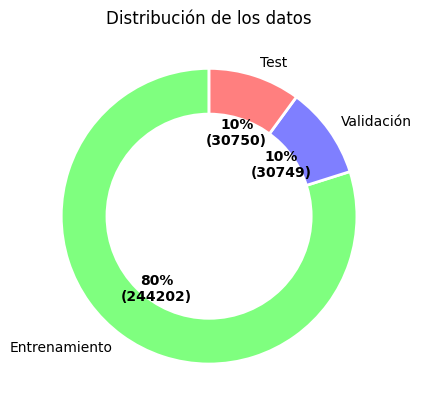

In [18]:
#Se reportan las cantidades y porcentajes
values = (len(y_train), len(y_val), len(y_test))
labels = ('Entrenamiento', 'Validación', 'Test')

# Crear el gráfico de rosquilla
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    values, labels=labels, colors=colors,
    autopct=lambda p: f'{p:.0f}%\n({int(p * sum(values) / 100)})',  # Muestra % y cantidad
    startangle=90, wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)

# Crear el agujero en el centro (para convertirlo en rosquilla)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Personalizar el texto
for text in autotexts:
    text.set_color('black')
    text.set_fontsize(10)
    text.set_weight(800)

# Título y mostrar
plt.title("Distribución de los datos")
plt.show()

Con el apoyo visual de estas dos últimas gráficas se observa que:
- El 80% de los datos pertenecen al conjunto de entrenamiento con 244.202 instancias, de las cuales, el 3,34% (8.151) son fraudulentas y el 96,66% (236.051) legítimas.
- El 10% de los datos pertenecen al conjunto de validación con 30.750 instancias, de las cuales, el 1,40% (431) son fraudulentas y el 98,60% (30.319) legítimas.
- El 10% de los datos pertenecen al conjunto de validación con 30.750 instancias, de las cuales, el 1,40% (431) son fraudulentas y el 98,60% (30.320) legítimas.

En total, se ha reducido el dataset de 1 millón de instancias a 305.702, es decir, una reducción de aproximadamente un 70%.

### Escalado de datos

Habitualmente se usa MinMaxScaler debido a que transforma los datos del dataset a un rango específico, generalmente [0, 1], lo que facilita el entrenamiento de redes neuronales. Este escalado permite que las características tengan magnitudes similares, evitando que aquellas con valores más grandes dominen el proceso de aprendizaje. Además, contribuye a una convergencia más rápida y estable durante el entrenamiento, ya que los algoritmos basados en gradientes funcionan mejor con datos normalizados. También preserva la distribución original de los datos, lo que es útil para mantener la interpretabilidad y evitar distorsiones en el modelo. Adicionalmente, el escalado es necesario para que ciertos algoritmos de sobremuestreo, como SMOTE, que se basan en cálculos de distancias, funcionen de manera eficaz, ya que garantiza que todas las características contribuyan equitativamente a la medición de distancias.

Es importante elegir el modelo del escalador, pues todos los datos se escalarán en base a este. Por ello, se entrenará la instancia de *MinMaxScaler* con el dataset previo a la división de entrenamiento, validación y test. De esta forma, se garantiza que los máximos y los mínimos cubren la mayor variabilidad posible.

In [19]:
# Crea una instancia de MinMaxScaler en base a df_encoded
scaler = MinMaxScaler() 
scaler.fit(df_encoded.drop(['month', 'fraud_bool'], axis = 1))
#Se transforman los datos de entrenamiento y validación
X_train_scaled, X_val_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

Al escalar los conjuntos de entrenamiento, validación y test, estos se convierten a *arrays* de *numpy*. Por lo tanto, también se convierte a este tipo de dato los valores de etiqueta.

In [20]:
#Se acondicionan y_train e y_val como arreglos de numpy
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

## Clustering

En este apartado, se busca la clusterización de las instancias con el fin de identificar patrones subyacentes en los datos, agrupar observaciones con características similares y explorar posibles segmentos dentro de las transacciones que ayuden a mejorar la detección de fraudes. Esto permitirá analizar si existen perfiles diferenciados de usuarios o comportamientos anómalos que puedan asociarse a actividades fraudulentas.

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
X_train_scaled_sample = X_train_scaled.copy()
y_train_sample = y_train.copy()

In [23]:
common_path = BASE_FOLDER / 'red_dim'
eps_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
min_samples_list = [3, 5, 10, 100, 1000, 50000, 100000]
labels_list = []
for eps in eps_list:
    for min_samples in min_samples_list:
        if Path(common_path / f'dbscan_labels_eps-{eps}_ms-{min_samples}.npy').exists():
            print(f"Cargando etiquetas de clusterización para epsilon = {eps}_ms-{min_samples}...")
            labels = np.load(common_path/ f'dbscan_labels_eps-{eps}_ms-{min_samples}.npy')
            labels_list.append(labels)
            print("Etiquetas cargadas existosamente...")
        else:
            print(f"Aplicando DBSCAN para generar etiquetas de clusterización para epsilon = {eps} y min_samples = {min_samples}...")
            # Aplicar DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_train_scaled_sample)
            np.save(common_path / f'dbscan_labels_eps-{eps}_ms-{min_samples}.npy', labels)
            labels_list.append(labels)
            print(f"Etiquetas generadas existosamente para epsilon = {eps} y min_samples = {min_samples}...")

Cargando etiquetas de clusterización para epsilon = 0.1_ms-3...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.1_ms-5...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.1_ms-10...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.1_ms-100...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.1_ms-1000...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.1_ms-50000...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.1_ms-100000...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.3_ms-3...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.3_ms-5...
Etiquetas cargadas existosamente...
Cargando etiquetas de clusterización para epsilon = 0.3_ms-10...
Etiquetas cargadas e

In [24]:
if Path(common_path / 'silhouette_avgs.pkl').exists():
    silhouette_avgs = joblib.load(common_path / 'silhouette_avgs.pkl')
else:
    print("Evaluando mediante la silueta todas las propuestas de clusterización...")
    silhouette_avgs = [
        silhouette_score(X_train_scaled_sample, labels) if len(np.unique(labels)) > 1 else 0 for labels in labels_list]
    joblib.dump(silhouette_avgs, common_path / 'silhouette_avgs.pkl')
    print("Evaluación completada")

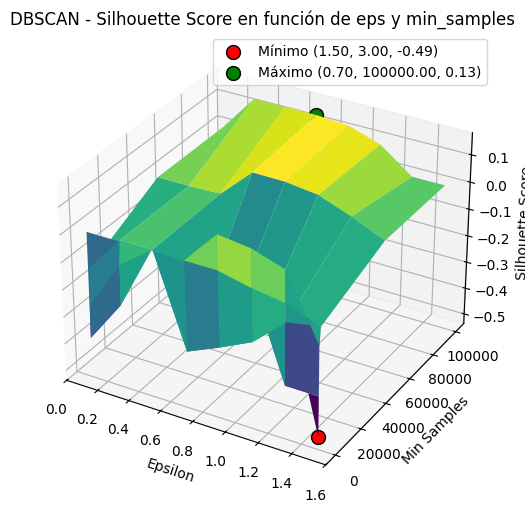

In [25]:
from mpl_toolkits.mplot3d import Axes3D

# Convertir listas a arrays para graficar
eps_values, min_samples_values = np.meshgrid(eps_list, min_samples_list)
silhouette_avgs = np.array(silhouette_avgs).reshape(len(min_samples_list), len(eps_list))

# Encontrar el índice del valor mínimo y máximo de Silhouette Score
min_index = np.unravel_index(np.argmin(silhouette_avgs), silhouette_avgs.shape)
max_index = np.unravel_index(np.argmax(silhouette_avgs), silhouette_avgs.shape)

# Coordenadas de los puntos mínimo y máximo
min_point = (eps_values[min_index], min_samples_values[min_index], silhouette_avgs[min_index])
max_point = (eps_values[max_index], min_samples_values[max_index], silhouette_avgs[max_index])

# Crear gráfico 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Graficar superficie 3D
ax.plot_surface(eps_values, min_samples_values, silhouette_avgs, cmap='viridis')

# Pintar los puntos mínimo y máximo
ax.scatter(*min_point, color='red', s=100, label=f'Mínimo ({min_point[0]:.2f}, {min_point[1]:.2f}, {min_point[2]:.2f})', edgecolors='black')
ax.scatter(*max_point, color='green', s=100, label=f'Máximo ({max_point[0]:.2f}, {max_point[1]:.2f}, {max_point[2]:.2f})', edgecolors='black')

# Etiquetas de los ejes
ax.set_xlabel('Epsilon')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('DBSCAN - Silhouette Score en función de eps y min_samples')

# Mostrar leyenda
ax.legend()

plt.show()

In [26]:
print(f'La cantidad óptima de clusters según el silhouette score son {len(np.unique(labels_list[np.argmax(silhouette_avgs)]))}')
labels = labels_list[np.argmax(silhouette_avgs)]
non_cluster_perc = len(labels[labels == -1]) / len(labels)
print(f"El porcentaje de transacciones no etiquetadas es un {non_cluster_perc:.2%}")

La cantidad óptima de clusters según el silhouette score son 2
El porcentaje de transacciones no etiquetadas es un 0.16%


In [27]:
np.unique(labels)

array([-1,  0], dtype=int64)

In [28]:
common_path = BASE_FOLDER / 'red_dim'
if Path(common_path / 'data_pca.pkl').exists():
    print("Cargando los datos de PCA...")
    # Cargar los datos PCA
    data_pca = joblib.load(common_path / 'data_pca.pkl')
    print("Datos de PCA cargados exitosamente")
else:
    print("Reduciendo dimensionalidad con PCA...")
    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(X_train_scaled_sample)
    joblib.dump(data_pca, common_path / 'data_pca.pkl')
    print("Dimensionalidad reducida a 2 dimensiones con PCA exitosamente")

if Path(common_path / 'data_tsne.pkl').exists():
    print("Cargando los datos de t-SNE...")
    # Cargar los datos t-SNE
    data_tsne = joblib.load(common_path / 'data_tsne.pkl')
    print("Datos de t-SNE cargados exitosamente")
else:
    print("Reduciendo dimensionalidad con t-SNE...")
    # Reducción de dimensionalidad con t-SNE
    tsne = TSNE(n_components=2)
    data_tsne = tsne.fit_transform(X_train_scaled_sample)
    joblib.dump(data_tsne, common_path / 'data_tsne.pkl')
    print("Dimensionalidad reducida a 2 dimensiones con t-SNE exitosamente")

Cargando los datos de PCA...
Datos de PCA cargados exitosamente
Cargando los datos de t-SNE...
Datos de t-SNE cargados exitosamente


C:\Users\Cristian\AppData\Local\Temp\ipykernel_32060\1118153120.py:55: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = axs[1, 0].scatter(data_pca[mask, 0], data_pca[mask, 1],
C:\Users\Cristian\AppData\Local\Temp\ipykernel_32060\1118153120.py:68: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = axs[1, 1].scatter(data_tsne[mask, 0], data_tsne[mask, 1],
C:\Users\Cristian\AppData\Local\Temp\ipykernel_32060\1118153

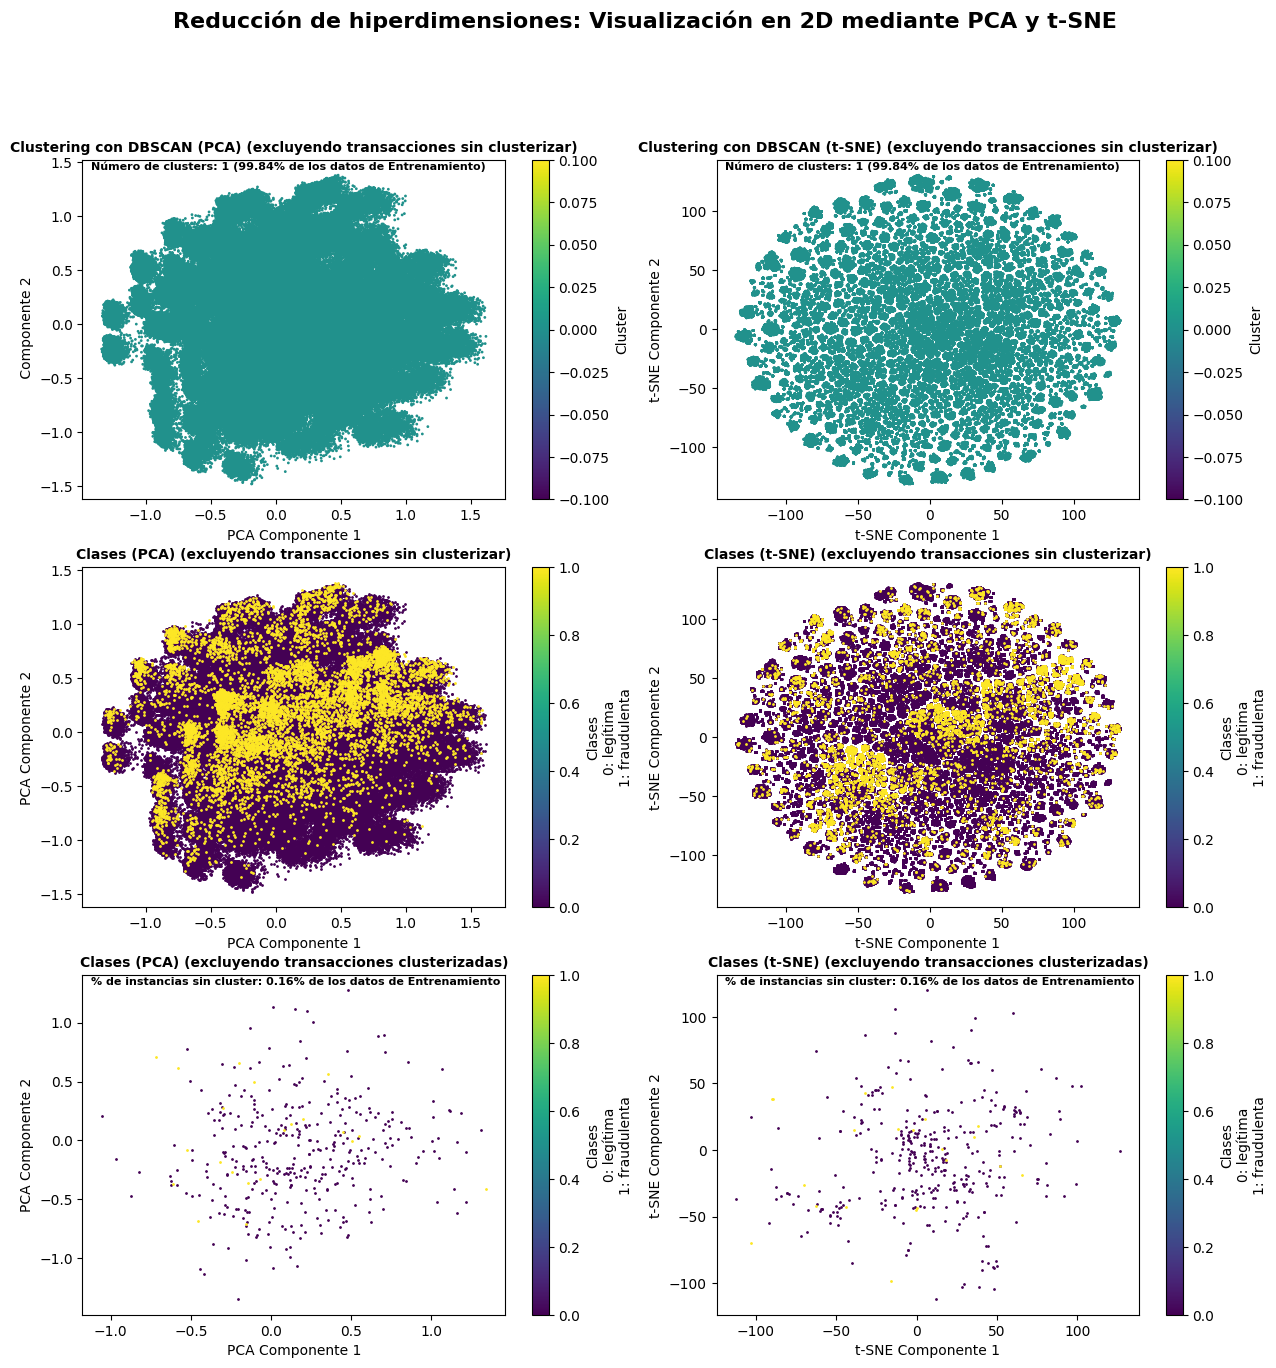

In [29]:
# Usar el colormap 'viridis' (puedes cambiarlo por otro)
colormap = plt.cm.viridis
# Número de colores que necesitas
num_colors = len(np.unique(labels))
# Generar una lista de num_colors colores equidistantes
discrete_colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]

# Se crea la figura
fig, axs = plt.subplots(3, 2, figsize=(15, 15))       

########### PCA: CLUSTERS (EXCLUYENDO SIN CLUSTERIZAR) #############
# Se crea una máscara para usar de filtro
mask = (labels > -1)
# Se plotea
scatter = axs[0, 0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                s=1,  # Tamaño de los puntos
                c = labels[mask], # Color según la etiqueta
                cmap = colormap,  # Mapa de color
                marker='o')  # Marcador tipo punto
# Se escribe en el gráfico el número total de clusters
axs[0, 0].text(0.02, 0.98, f'Número de clusters: {num_colors - 1} ({1-non_cluster_perc:.2%} de los datos de Entrenamiento)', 
         transform = axs[0, 0].transAxes, ha='left', va='center',
         fontweight = 'bold', fontsize = 8, color = 'black')
# Se definen los nombres de ejes y título 
axs[0, 0].set_xlabel('PCA Componente 1')
axs[0, 0].set_ylabel(' Componente 2')
axs[0, 0].set_title('Clustering con DBSCAN (PCA) (excluyendo transacciones sin clusterizar)',
          fontweight = 'bold', fontsize = 10)
# Se crea una leyenda de gradiente de color
fig.colorbar(scatter, ax = axs[0, 0], label='Cluster')


########### t-SNE: CLUSTERS (EXCLUYENDO SIN CLUSTERIZAR) #############
# Se crea una máscara para usar de filtro (se excluyen los no clusterizados)
mask = (labels > -1)
scatter = axs[0, 1].scatter(data_tsne[mask, 0], data_tsne[mask, 1], 
                s=1, c = labels[mask], cmap = colormap,
                marker='o')
# Se escribe en el gráfico el número total de clusters
axs[0, 1].text(0.02, 0.98, f'Número de clusters: {num_colors - 1} ({1-non_cluster_perc:.2%} de los datos de Entrenamiento)', 
         transform = axs[0, 1].transAxes, ha='left', va='center',
         fontweight = 'bold', fontsize = 8, color = 'black')
axs[0, 1].set_xlabel('t-SNE Componente 1')
axs[0, 1].set_ylabel('t-SNE Componente 2')
axs[0, 1].set_title('Clustering con DBSCAN (t-SNE) (excluyendo transacciones sin clusterizar)',
          fontweight = 'bold', fontsize = 10)
fig.colorbar(scatter, ax = axs[0, 1], label='Cluster')


########### PCA: CLASES (EXCLUYENDO SIN CLUSTERIZAR) #############
# Se itera sobre cada clase de 'y_train_sample'
for y_label in np.unique(y_train_sample):  
    # Se crea una máscara para usar de filtro (se filtra por la etiqueta iterada y excluyendo los NO clusterizados)
    mask = ((y_train_sample == y_label) & (labels > -1))
    scatter = axs[1, 0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                s=1,  # Tamaño de los puntos
                c = discrete_colors[y_label * (- 1)], # Colores extremos del colormap en colores discretos
                marker='o')
axs[1, 0].set_xlabel('PCA Componente 1')
axs[1, 0].set_ylabel('PCA Componente 2')
axs[1, 0].set_title('Clases (PCA) (excluyendo transacciones sin clusterizar)',
          fontweight = 'bold', fontsize = 10)
fig.colorbar(scatter, ax = axs[1, 0], label='Clases\n0: legítima\n1: fraudulenta')

########### t-SNE: CLASES (EXCLUYENDO SIN CLUSTERIZAR) #############
for y_label in np.unique(y_train_sample):
    mask = ((y_train_sample == y_label) & (labels > -1))
    scatter = axs[1, 1].scatter(data_tsne[mask, 0], data_tsne[mask, 1], 
                s=1, c = discrete_colors[y_label * (-1)],
                marker='o')
axs[1, 1].set_xlabel('t-SNE Componente 1')
axs[1, 1].set_ylabel('t-SNE Componente 2')
axs[1, 1].set_title('Clases (t-SNE) (excluyendo transacciones sin clusterizar)',
          fontweight = 'bold', fontsize = 10)
fig.colorbar(scatter, ax = axs[1, 1], label='Clases\n0: legítima\n1: fraudulenta')

########### PCA: CLASES (EXCLUYENDO CLUSTERIZADAS) #############
for y_label in np.unique(y_train_sample):
    # Se crea una máscara para usar de filtro (se filtra por la etiqueta iterada y excluyendo los clusterizados)
    mask = ((y_train_sample == y_label) & (labels == -1)) 
    scatter = axs[2, 0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
                s=1,  # Tamaño de los puntos
                c = discrete_colors[y_label * (- 1)], 
                marker='o')
# Se escribe en el gráfico el % de instancias sin clusterizar
axs[2, 0].text(0.02, 0.98, f'% de instancias sin cluster: {non_cluster_perc:.2%} de los datos de Entrenamiento', 
         transform = axs[2, 0].transAxes, ha='left', va='center',
         fontweight = 'bold', fontsize = 8, color = 'black')
axs[2, 0].set_xlabel('PCA Componente 1')
axs[2, 0].set_ylabel('PCA Componente 2')
axs[2, 0].set_title('Clases (PCA) (excluyendo transacciones clusterizadas)',
          fontweight = 'bold', fontsize = 10)
fig.colorbar(scatter, ax = axs[2, 0], label='Clases\n0: legítima\n1: fraudulenta')

########### t-SNE: CLASES (EXCLUYENDO CLUSTERIZADAS) #############
for y_label in np.unique(y_train_sample):
    mask = ((y_train_sample == y_label) & (labels == -1))
    scatter = axs[2, 1].scatter(data_tsne[mask, 0], data_tsne[mask, 1], 
                s=1, c = discrete_colors[y_label * (-1)], 
                marker='o')
# Se escribe en el gráfico el % de instancias sin clusterizar
axs[2, 1].text(0.02, 0.98, f'% de instancias sin cluster: {non_cluster_perc:.2%} de los datos de Entrenamiento', 
         transform = axs[2, 1].transAxes, ha='left', va='center',
         fontweight = 'bold', fontsize = 8, color = 'black')
axs[2, 1].set_xlabel('t-SNE Componente 1')
axs[2, 1].set_ylabel('t-SNE Componente 2')
axs[2, 1].set_title('Clases (t-SNE) (excluyendo transacciones clusterizadas)',
          fontweight = 'bold', fontsize = 10)
fig.colorbar(scatter, ax = axs[2, 1], label='Clases\n0: legítima\n1: fraudulenta')
# Se ajusta la gráfica y se muestra
fig.suptitle('Reducción de hiperdimensiones: Visualización en 2D mediante PCA y t-SNE',
             fontweight = 'bold', fontsize = 16)

plt.show()

La distribución de los datos en las gráficas, así como la información previa expuesta, revelan que:

- El número de clusters óptimo según el algoritmo DBSCAN, dentro de las pruebas realizadas (30 combinaciones diferentes de epsilon y min_samples) y evaluadas con la métrica de la Silueta, es 1 sola agrupación válida y el resto pertenece al grupo de los no categorizados o ruido.
- Aproximadamente el 2% de las transacciones no pertenecen a ningún cluster, las cuales no presentan una distinción con respecto a las clusterizadas con respecto a la clase.
- La dispersión de los datos en ambas representaciones (PCA y t-SNE) indica que no hay una clara separación entre transacciones fraudulentas y no fraudulentas, lo que sugiere que las características utilizadas podrían no ser suficientes para diferenciar de manera efectiva ambos tipos de transacciones tras la reducción de dimensionalidad.
- La visualización mediante t-SNE muestra una distribución más esférica de los datos, mientras que PCA preserva una estructura más lineal. Sin embargo, en ambos casos, los fraudes no forman conglomerados diferenciados, sino que están dispersos entre las transacciones normales.
- La nula creación de variedad de clústeres y el bajo valor de la Silueta muestran que DBSCAN no ha sido útil para una clasificación efectiva mediante clusterización.

Ha de tenerse en cuenta que la visualización 2D tras la reducción de dimensionalidad es una forma de visualizar hiperdimensiones proyectadas, es decir, los patrones podrían existir pero no visualizarse correctamente. Sin embargo, en conjunto con los cálculos y evaluaciones (como la cantidad de clústeres y la métrica de la Silueta), se demuestra que, al menos, los datos no presentan agrupaciones globulares claras y uniformemente densas, ya que, si fuera así, *DBSCAN* habría obtenido mejores resultados.

Aunque podrían evualuarse múltiples formas de clusterización con otros algoritmos como *k-means* o agrupaciones no esféricas como *Modelos Mixtos Gaussianos*, queda demostrada la suficiente complejidad del problema como justificación del uso de redes neuronales para la detección de fraudes del dataset presentado.

# Redes Neuronales Produndas

Dada la complejidad de los datos, el uso de redes neuronales es adecuado por las siguientes razones:

1- Captura de Relaciones No Lineales

- Modelos tradicionales como regresión logística o árboles de decisión pueden no captar bien relaciones complejas entre variables.
- Las redes neuronales pueden modelar interacciones entre múltiples variables sin necesidad de especificarlas manualmente.

2- Capacidad para Manejar Datos Multimodales

- La presencia de distribuciones multimodales y patrones complejos sugiere que se requieren modelos con alta capacidad de representación.
- Las redes neuronales pueden aprender representaciones más abstractas y combinaciones de variables relevantes para mejorar la clasificación.

3- Escalabilidad con Grandes Volúmenes de Datos

- En detección de fraude, la cantidad de datos suele ser grande y con un alto número de características.
- Las redes neuronales, especialmente las arquitecturas profundas, pueden escalar mejor y aprender patrones en conjuntos de datos masivos.

## Descripción del experimento

Se van a diseñar dos redes neuronales de distinta naturaleza para resolver el mismo problema:

- Red Neuronal Profunda (*DNN*)
- Red Neuronal Convolucional (*CNN*):

Una vez configurada la arquitectura de la *DNN*, se crearán distintos modelos compilándolos con distintos parámetros y entrenándolos con disintos datos de entrenamiento (sin aumentar y aumentados). Como el poder de computación es limitado, no se utilizará un algoritmo de optimización como *algoritmo genético* o *RandomSearchCV* y variantes para la búsqueda de los mejores parámetros debido a la gran cantidad de datos a entrenar (a pesar del submuestreo realizado en pasos anteriores), sino que se seguirá la siguiente estrategia:

- Entrenamiento de la *DNN* sin balanceo de clases en la red neuronal ni en el dataset: mediante el argumento *class_weight* del método *fit* de un modelo compilado, se puede pasar un diccionario con distintos pesos según la clase y los parámetros de la red se actualizarán durante el *backpropagation* de forma no igualitaria, sino según los pesos proporcionados para cada clase. En este escenario, este diccionario tendrá un peso 1:1 para ambas clases. Es decir, es como si no se usara. Además, se utilizarán los datos de entrenamiento sin balancear con la descompensación vista.
- Entrenamiento de la *DNN* con balanceo de clases en la red neuronal pero no en el dataset: en este caso, se calcularán los valores para el *class_weight* mediante *compute_class_weight* de *sklearn* para entrenar la red considerando los pesos de las clases.
- Entrenamiento de la *DNN* con balanceo de clases en la red neuronal y en el dataset:
  - Balanceo del dataset mediante una *Red Neuronal Generativa Adversarial Concional Tabular* (*CTGAN* por sus siglas en inglés): gracias a las redes neuronales adversariales se pueden crear datos sintéticos a partir de una muestra data. Popularmente, se utiliza para la generación de imágenes y vídeos. Sin embargo, en este escenario se utilizará para crear instancias sintéticas tabulares del dataset, concretamente, del tipo minoritario.
  - Balanceo del dataset mediante el algoritmo *SMOTE*
- Para cada uno de los casos expuestos, se crearán tres modelos distintos variando el *dropout* para seleccionar el modelo que mejor resultados obtenga tratando de evitar el sobreajuste. Hasta el momento, esto hace el total de 9 modelos distintos, los cuales se someterán a una evaluación visual de las pérdidas de entrenamiento y las métricas clásicas de entrenamiento, validación y test.
- De las tres pruebas expuestas, se escogerá la que genere el modelo más sencillo que cumpla con los criterios de éxito y se repetirá la misma prueba para la *CNN* (es decir, si se aumentan los datos de entrenamiento o si se utiliza el balanceo de clases en el propio entrenamiento de la red o ambas cosas).
- Para el entrenamiento de la *CNN* se realizará una transformación de vector de instancia de transacción en una imagen mediante un procedimiento explicado próximamente.
- Por último, se desarrollará un modelo combinado DNN+CNN, usando los modelos ya entrenados, pero combinando la predicción en la última capa de salida.

Una vez se ha llevado a cabo todo este proceso, se evaluarán los resultados finales y se sacarán conclusiones.


## Criterios de Comparación de Modelos: métricas y umbrales

Dado que el fraude es un evento poco frecuente y de alto costo, la métrica más relevante no suele ser la exactitud (accuracy), sino otras que capturen el equilibrio entre detección de fraudes y falsos positivos. A continuación, se describirán las métricas usadas para la comparación de los distintos modelos:

- Sensibilidad (*Recall*): Es la métrica más importante en detección de fraudes, ya que mide la proporción de fraudes reales que el modelo detecta correctamente. Un modelo con alta sensibilidad es preferible, incluso si tiene una precisión ligeramente menor.
- Precisión: Mide la proporción de transacciones identificadas como fraudulentas que realmente lo son. Una alta precisión reduce los falsos positivos, lo que es importante para evitar molestias a los clientes.
- AUC-ROC: Esta métrica es útil para comparar modelos en términos de su capacidad para distinguir entre clases (fraude vs no fraude) a través de todos los umbrales de decisión. Un AUC más alto indica un mejor rendimiento general.
- Exactitud (*Accuracy*): Es menos relevante en problemas con clases desbalanceadas, como el fraude, donde la clase minoritaria (fraude) es la más importante.

Además, se va a usar la **Matriz de confusión**, la cual da una visión detallada de los falsos positivos (*FP*) y los falsos negativos (*FN*), prestando especial atención a estos últimos ya que representan los fraudes no detectados.

Por otro lado, en el entrenamiento de las redes neuronales profundas, las métricas de pérdida (loss) son fundamentales para evaluar cómo el modelo está aprendiendo y generalizando. Estas métricas miden la discrepancia entre las predicciones del modelo y los valores reales. Un buen modelo debe tener una pérdida de validación que disminuya y se estabilice con las iteraciones de entrenamiento (*epochs*). Para elegir bien el modelo, se debe prestar atención a las siguientes características:
- Pérdida de validación estable.
- Mínimo sobreajuste.
- Comparación de pérdidas entre los distintos modelos.

## Carga de librerías

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import F1Score, Recall, Precision, AUC
import tensorflow as tf

## Funciones personalizadas

La función *plot_model_hist* se usa para plotear sobre dos gráficas diferenciadas tanto las pérdidas del modelo entrenado como sus métricas de entrenamiento y validación.

In [31]:
def plot_model_hist(history, ax1, ax2):
    # Pintan las gráficas
    n_epochs = len(history['accuracy'])

    ax1.plot(np.arange(0, n_epochs), history["loss"], 'r-', label="train_loss")
    ax1.plot(np.arange(0, n_epochs), history["val_loss"], 'b-', label="val_loss")
    ax1.set_title("Pérdidas Entrenamiento y Validación", fontsize = 12, fontweight = 'bold')
    ax1.set_xlabel("Epoch")
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Fuera a la derecha

    ax2.plot(np.arange(0, n_epochs), history["accuracy"], 'k--',label="train_acc")
    ax2.plot(np.arange(0, n_epochs), history["val_accuracy"], 'k-',label="val_acc")
    ax2.plot(np.arange(0, n_epochs), history["precision"], 'b--',label="prec")
    ax2.plot(np.arange(0, n_epochs), history["val_precision"], 'b-',label="val_prec")
    ax2.plot(np.arange(0, n_epochs), history["recall"], 'r--',label="recall")
    ax2.plot(np.arange(0, n_epochs), history["val_recall"], 'r-',label="val_recall")
    ax2.plot(np.arange(0, n_epochs), history["AUC"], 'm--',label="AUC")
    ax2.plot(np.arange(0, n_epochs), history["val_AUC"], 'm-',label="val_AUC")
    ax2.set_title("Métricas Entrenamiento y Validación", fontsize = 12, fontweight = 'bold')
    ax2.set_xlabel("Epoch")
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Fuera a la derecha

    return ax1, ax2

*plot_metrics*, al igual que la anterior, también grafica la evaluación de las métricas, pero en esta ocasión sobre el conjunto de test e iterando sobre distintos umbrales (*thresholds*)

In [32]:
def plot_metrics(y_pred_prob, y_test, ax):
  # Se definen listas para almacenar los valores a graficar
  thresholds = np.arange(0, 1, 0.01)
  acc = []
  recall = []
  precision = []
  roc_auc = []

  for threshold in thresholds:
      # Se calculan las predicciónes para el umbral determinado
      y_pred = (y_pred_prob > threshold).astype(int)
      '''
      #Se imprimen las métricas
      class_report = (classification_report(y_test, y_pred))
      print(f"Umbral: {threshold}")
      print(class_report)
      '''
      # Se adjuntan las métricas a las listas
      acc.append(accuracy_score(y_test, y_pred))
      recall.append(recall_score(y_test, y_pred))
      precision.append(precision_score(y_test, y_pred))
      roc_auc.append(roc_auc_score(y_test, y_pred))

  ax.plot(thresholds, acc, 'k-', label = 'Accuracy')
  ax.plot(thresholds, recall, 'r-', label = 'Recall')
  ax.plot(thresholds, precision, 'b-', label = 'Precision')
  ax.plot(thresholds, roc_auc, 'm-', label = 'ROC_AUC')

  # Cálculo del máximo roc_auc
  max_roc_auc = max(roc_auc)
  index = roc_auc.index(max_roc_auc)
  opt_threshold = thresholds[index]
  # Precisión para este umbral
  precision_opt_tr = precision[index]
  # Sensibilidad para este umbral
  recall_opt_tr = recall[index]
  # Exactitud para este umbral
  acc_opt_tr = acc[index]
                               
  # Se anota el punto óptimo de la curca AUC-ROC
  ax.scatter(opt_threshold, max_roc_auc, color = 'green', zorder = 0)
  ax.annotate(f'Max ROC-AUC = ({opt_threshold:.2f},{max_roc_auc:.3f})',
              xy = (opt_threshold, max_roc_auc),
              xytext = (0.05 + opt_threshold, max_roc_auc),
              arrowprops = dict(arrowstyle = '->'),
              fontsize = 5,
              fontweight = 'bold')
  
  # Se anota el punto de la precisión para el umbral seleccionado
  ax.scatter(opt_threshold, precision_opt_tr, color = 'blue', zorder = 0)
  ax.annotate(f'Prec = ({opt_threshold:.2f},{precision_opt_tr:.3f})',
              xy = (opt_threshold, precision_opt_tr),
              xytext = (opt_threshold, 0.25 + precision_opt_tr),
              arrowprops = dict(arrowstyle = '->'),
              fontsize = 5,
              fontweight = 'bold')
  
  # Se anota el punto de la sensibilidad para el umbral seleccionado
  ax.scatter(opt_threshold, recall_opt_tr, color = 'blue', zorder = 0)
  ax.annotate(f'Recall = ({opt_threshold:.2f},{recall_opt_tr:.3f})',
              xy = (opt_threshold, recall_opt_tr),
              xytext = (opt_threshold, recall_opt_tr - 0.25),
              arrowprops = dict(arrowstyle = '->'),
              fontsize = 5,
              fontweight = 'bold')
  
  # Se anota el punto de la exactitud para el umbral seleccionado
  ax.scatter(opt_threshold, acc_opt_tr, color = 'blue', zorder = 0)
  ax.annotate(f'Acc = ({opt_threshold:.2f},{acc_opt_tr:.3f})',
              xy = (opt_threshold, acc_opt_tr),
              xytext = (opt_threshold, acc_opt_tr + 0.15),
              arrowprops = dict(arrowstyle = '->'),
              fontsize = 5,
              fontweight = 'bold')
  
  # Se grafica una línea vertical
  ax.axvline(opt_threshold, color = 'black', linestyle = '--', linewidth = 0.5)

  # Añadir leyenda, título y etiquetas
  ax.set_title(f'Métricas Test',
               fontsize = 12, fontweight = 'bold')
  ax.set_xlabel('Umbral')
  ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Fuera a la derecha

  return ax, opt_threshold


*plot_cm* grafica también la matriz de confusión

In [33]:
def plot_cm(y_pred_prob, y_test, ax, threshold):
  # Se obtienen las predicciones
  y_pred = (y_pred_prob > threshold).astype(int)
  # Se crea la matriz de confusión
  cm = confusion_matrix(y_test, y_pred)
  # Se crea un heatmap con seaborn
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Clase 0', 'Clase 1'],
              yticklabels=['Clase 0', 'Clase 1'], ax = ax)

  ax.set_xlabel('Predicción')
  ax.set_ylabel('Verdadero')
  ax.set_title(f'Matriz de Confusión: Umbral = {threshold}')
  return ax

Por último, se crea la función *plot_fig_metrics*, que crea la figura y llama a las anteriores para crear un gráfico combinado 

In [34]:
def plot_fig_metrics(models, histories, X_test, y_test, dropouts, name, lr):
  cols = len(dropouts)
  fig, axs = plt.subplots(4, cols, figsize=(21, 15))
  # Aplanar la matriz de ejes para iterar más fácilmente
  #axs = axs.flatten()
  for i, model in enumerate(models):
    # Se crea un contador para cada ax
    c = 0
    # Se plotean las métricas de entrenamiento
    plot_model_hist(histories[i], ax1=axs[c, i], ax2=axs[c + 1, i])
    c += 2
    # Se plotean las métricas de test
    y_pred_prob = model.predict(X_test)
    _, opt_threshold = plot_metrics(y_pred_prob, y_test, ax=axs[c, i])
    c += 1
    plot_cm(y_pred_prob, y_test, ax=axs[c, i], threshold = opt_threshold)

  # Se agrega un título general a la figura
  fig.suptitle(f'Comparación de las distintas métricas según el valor del dropout y del umbral de clasificación\n Modelo: {name} con Learning Rate = {lr}',
              fontsize = 24, fontweight = 'bold')

  # Se agrega títulos a las columnas
  fig.text(0.15, 0.92, f"Dropout = {dropouts[0]}", ha='center', fontsize=18, fontweight='bold')
  fig.text(0.5, 0.92, f"Dropout = {dropouts[1]}", ha='center', fontsize=18, fontweight='bold')
  fig.text(0.85, 0.92, f"Dropout = {dropouts[2]}", ha='center', fontsize=18, fontweight='bold')

  fig.tight_layout(rect=[0, 0, 1, 0.96])
  file_name = name + '_lr-' + str(lr) + '_metrics.png'
  plt.savefig(Path(BASE_FOLDER / 'figs' / file_name))
  plt.show()  # Mostrar todas las gráficas juntas


La función *train_load_model* es llamada para entrenar un modelo definido o bien, en caso de que ya exista en el directorio, cargar el modelo y su historia de entrenamiento.

In [35]:
from keras.models import load_model

def train_load_model(func_model, model_name, hist_name, X_train, y_train, X_val, y_val, epochs, lr, dropout, class_weight_dict):
  model_name = model_name + '_dropout-' + str(dropout) + '_lr-' + str(lr) + '.h5'
  hist_name = hist_name  + '_dropout-' + str(dropout) + '_lr-' + str(lr) +  '.json'
  if Path(BASE_FOLDER / 'models' / model_name).exists() and Path(BASE_FOLDER / 'models' / hist_name).exists():
    model = load_model(Path(BASE_FOLDER / 'models' / model_name))
    history = json.load(open(Path(BASE_FOLDER / 'models' / hist_name), 'r'))
  else:
    model, H = func_model(X_train, y_train, X_val, y_val, epochs, lr, dropout, class_weight_dict)
    # Almacenamos el modelo empleando la función mdoel.save de Keras
    model.save(Path(BASE_FOLDER / 'models' / model_name))
    # Guardar historial de entrenamiento
    json.dump(H.history, open(Path(BASE_FOLDER / 'models' / hist_name), 'w'), indent = 6)
    # Se carga solo la history
    history = json.load(open(Path(BASE_FOLDER / 'models' / hist_name), 'r'))

  return model, history

La función *test_model* es un paso previo a train_load_model*, en donde se calculan ciertos parámetros como el balanceo de clases, se definen los dropouts a evaluar y se crean diccionarios para almacenar los distintos modelos con los diferentes parámetros.

In [36]:
def test_model(func_model, model_name, hist_name, X_train, y_train, X_val, y_val, epochs, lr, balance_class = False):
    # Calcular pesos de las clases para balancear
    if balance_class == False:
        class_weight_dict = {0: 1.0, 1: 1.0}
    else:
        class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.flatten()), y=y_train.flatten())
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Pesos de clase: {class_weight_dict}")
    
    dropouts = [0, 0.33, 0.5]
    models = []
    histories = []
    for dropout in dropouts:
        model, history = train_load_model(func_model, model_name, hist_name,
                                        X_train, y_train, X_val, y_val, 
                                        epochs, lr, dropout, class_weight_dict)
        models.append(model)
        histories.append(history)
    return models, histories, dropouts

## Red Neuronal Densa (DNN)

### Desarrollo de la arquitectura de la DNN

In [37]:
#Se transforma la forma de los valores "y" (excepto y_train, que se le harán más transformaciones)
#y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [38]:
def train_DNN(X_train, y_train, X_val, y_val, epochs, lr, dropout, class_weight_dict):

    # Construcción del modelo
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Salida binaria
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy', Precision(name = 'precision'),
                         Recall(name = 'recall'),
                         F1Score(average = 'macro',name = 'f1'),
                         AUC(name="AUC")])
    model.summary()
    # Entrenar el modelo con pesos de clase
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    H = model.fit(X_train, y_train,
            epochs=epochs, batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            class_weight=class_weight_dict,
            shuffle = True)
    return model, H

### DNN Tests

#### Entrenamiento sin Balanceo de clases en red neuronal ni dataset

Pesos de clase: {0: 1.0, 1: 1.0}


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,985 (789.00 KB)

 Trainable params: 200,065 (781.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.7993 - accuracy: 0.9640 - f1: 0.0643 - loss: 0.1344 - precision: 0.3391 - recall: 0.0390 - val_AUC: 0.8778 - val_accuracy: 0.9852 - val_f1: 0.0276 - val_loss: 0.0618 - val_precision: 0.3883 - val_recall: 0.0928
Epoch 2/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.8688 - accuracy: 0.9675 - f1: 0.0639 - loss: 0.1076 - precision: 0.5597 - recall: 0.0628 - val_AUC: 0.8760 - val_accuracy: 0.9855 - val_f1: 0.0276 - val_loss: 0.0637 - val_precision: 0.4118 - val_recall: 0.0812
Epoch 3/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.8788 - accuracy: 0.9671 - f1: 0.0654 - loss: 0.1072 - precision: 0.6031 - recall: 0.0757 - val_AUC: 0.8743 - val_accuracy: 0.9859 - val_f1: 0.0276 - val_loss: 0.0589 - val_precision: 0.4615 - val_recall: 0.0418
Epoch 4/50
3816/3816 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.8839 - accuracy: 0.9674 - f1: 0.0645 - loss: 0.1046 - precision: 0.5859 - recall: 0.0765 - val_AUC: 0.8801 - va

961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

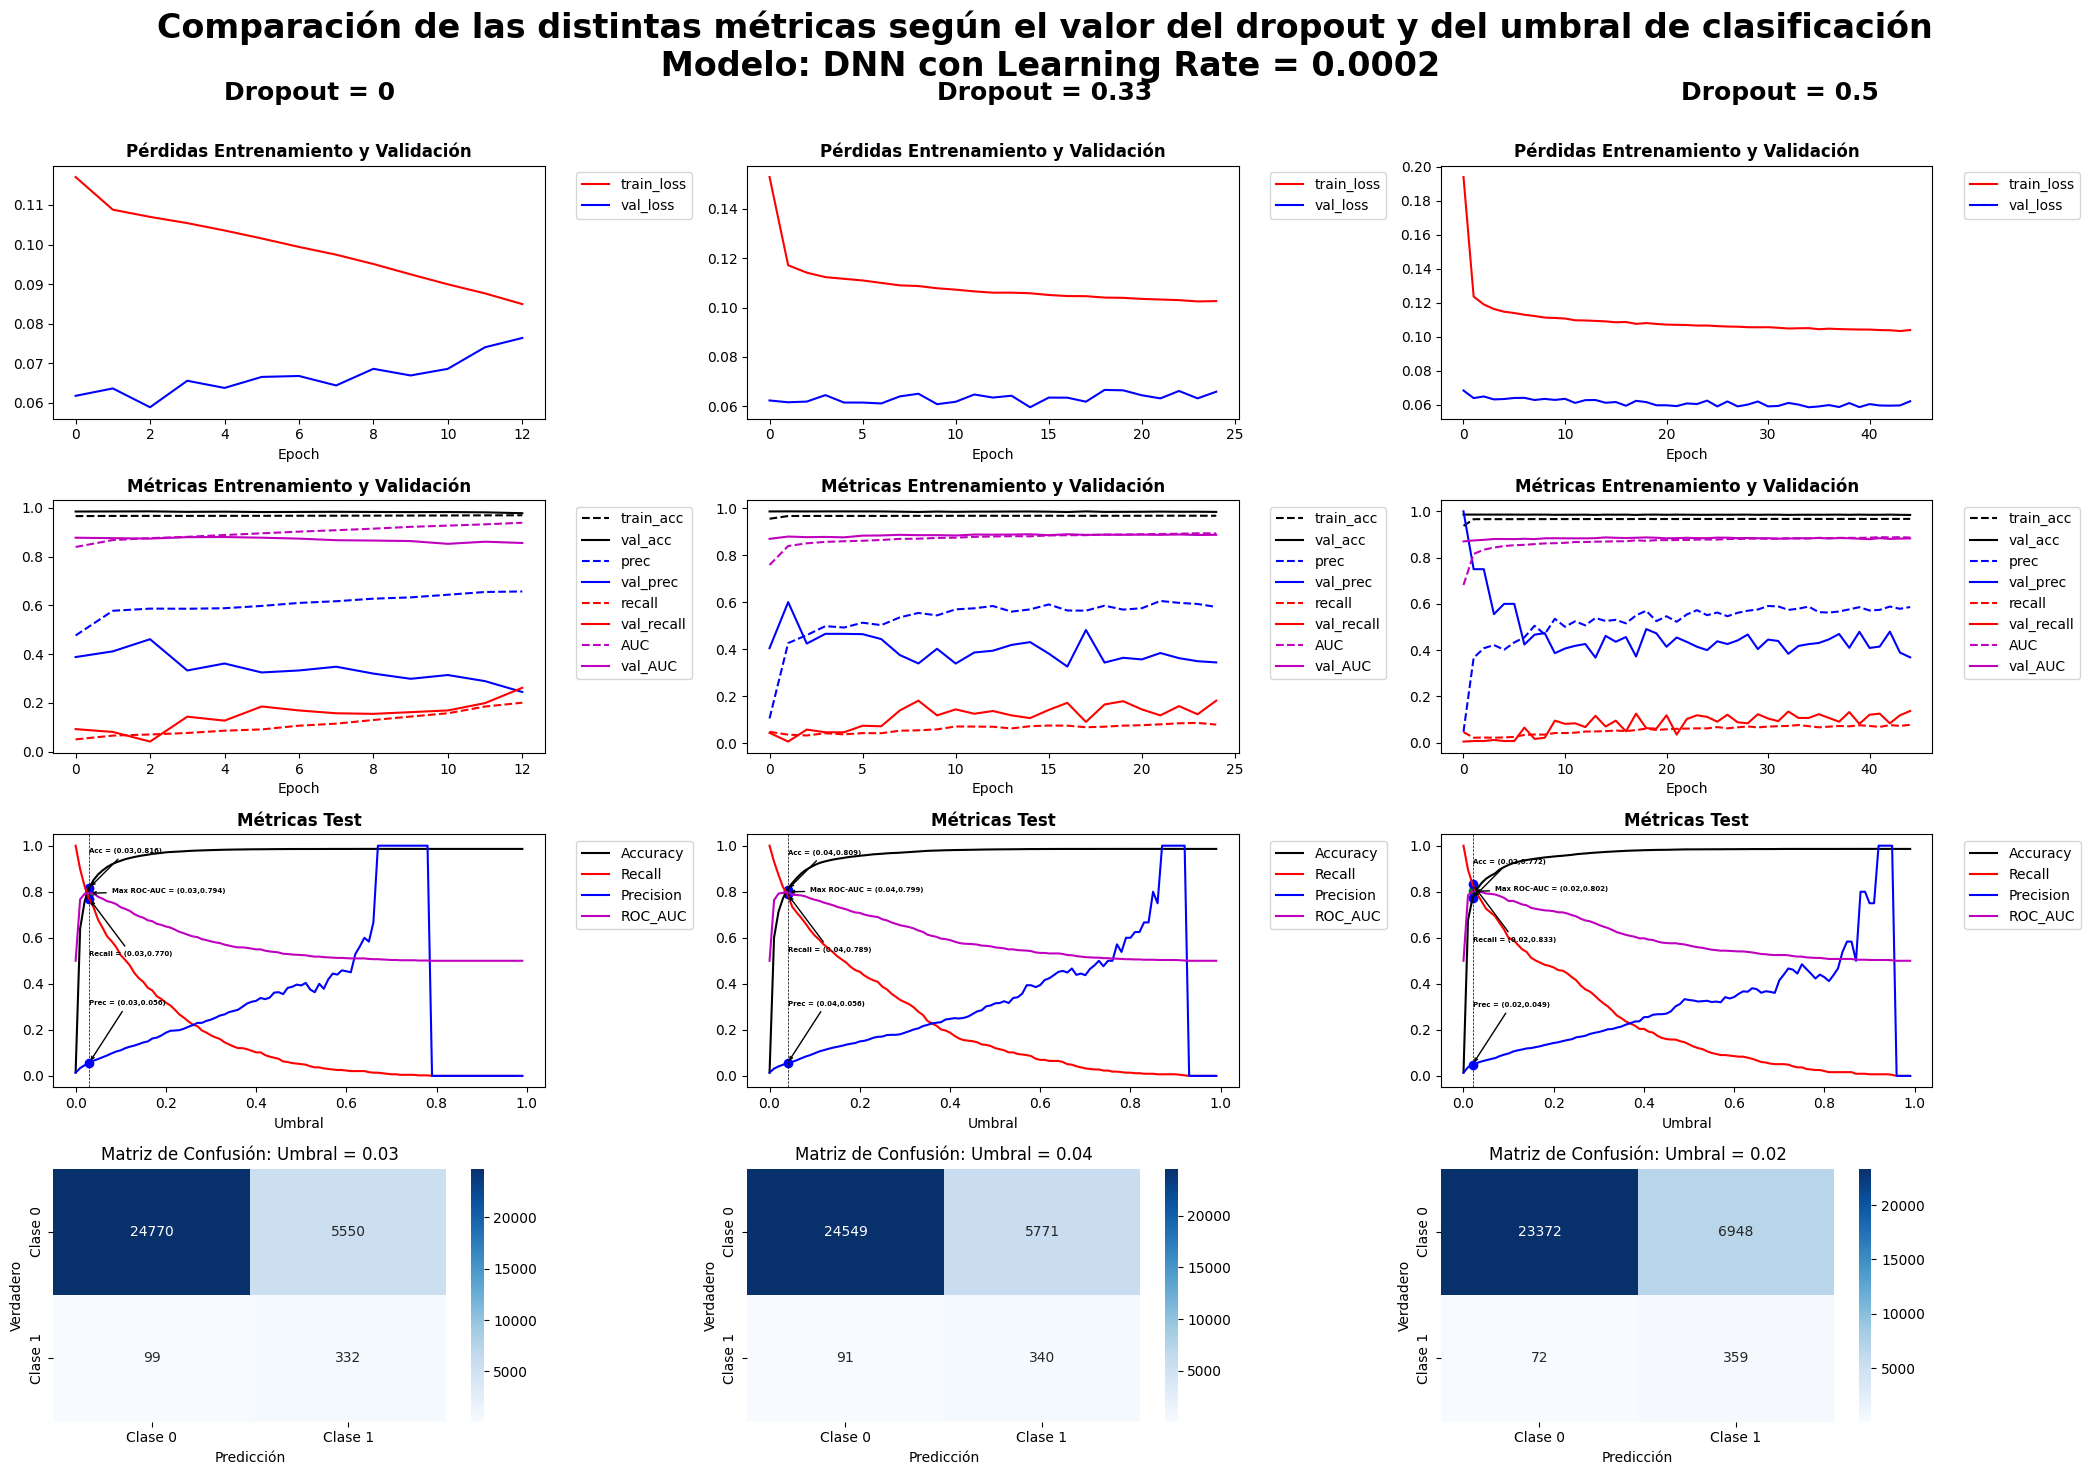

In [39]:
root_name = 'DNN'
epochs = 50
lr = 0.0002
dnn_models, dnn_histories, dropouts = test_model(train_DNN, root_name, f'{root_name}_hist', 
                                       X_train_scaled, y_train.reshape(-1, 1), X_val_scaled, y_val, 
                                       epochs, lr, balance_class = False)
plot_fig_metrics(dnn_models, dnn_histories, X_test_scaled, y_test, dropouts, root_name, lr)

#### Entrenamiento con Balanceo de clases en red neuronal

Pesos de clase: {0: 0.51726533672808, 1: 14.979879769353454}


961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


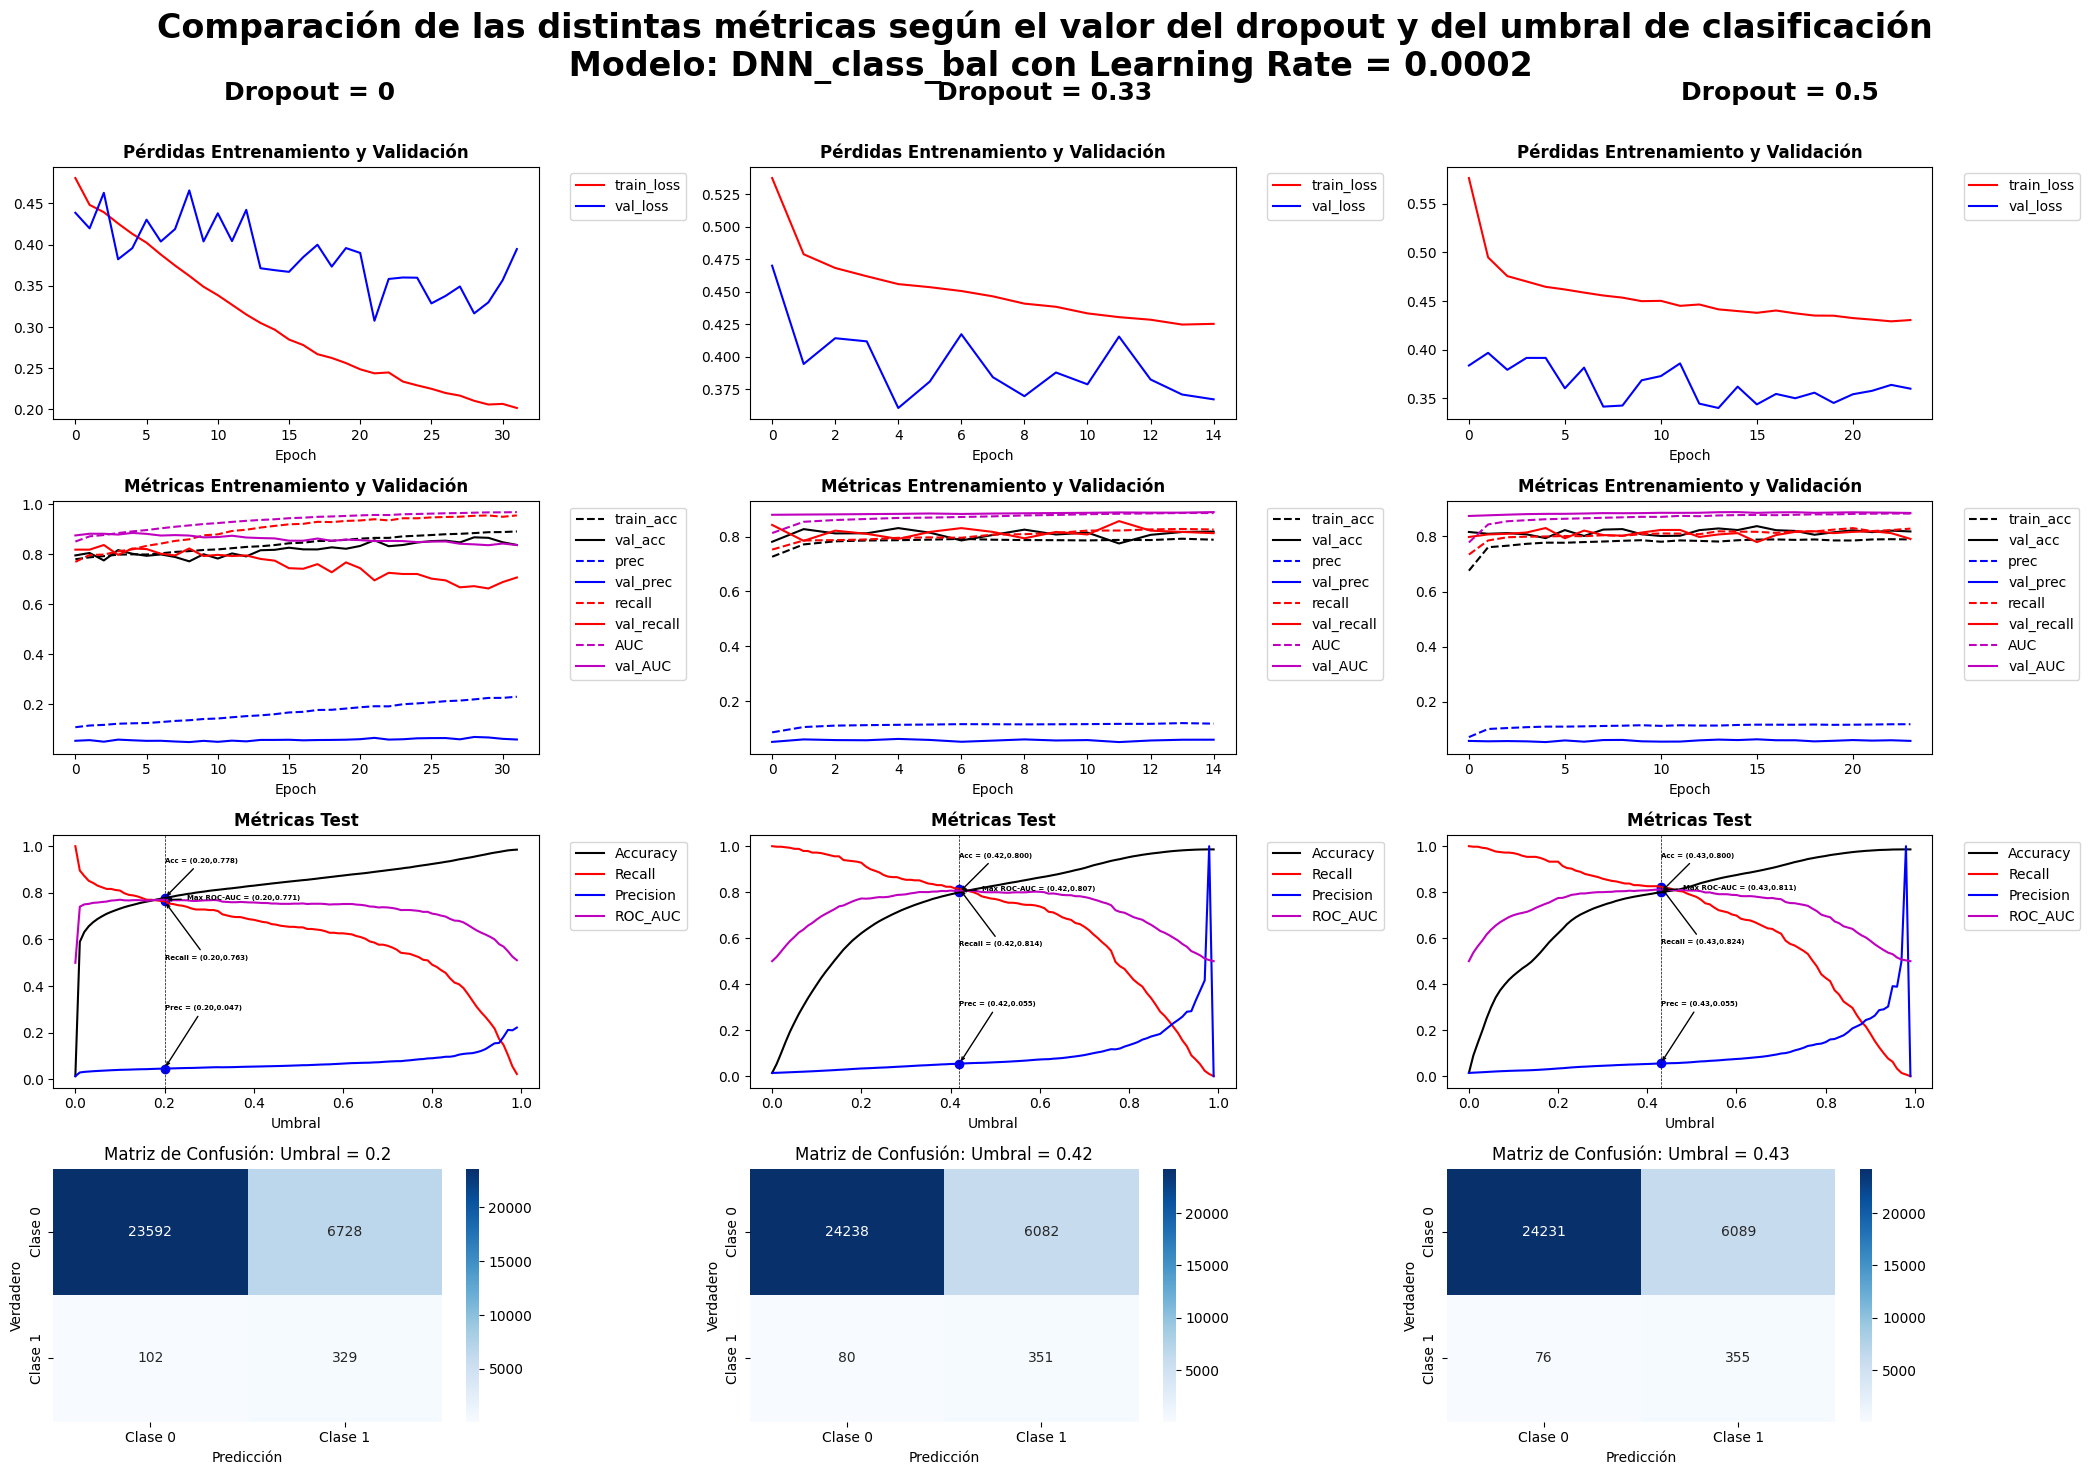

In [40]:
root_name = 'DNN_class_bal'
epochs = 50
lr = 0.0002
dnn_models, dnn_histories, dropouts = test_model(train_DNN, root_name, f'{root_name}_hist', 
                                       X_train_scaled, y_train.reshape(-1, 1), X_val_scaled, y_val, 
                                       epochs, lr, balance_class = True)
plot_fig_metrics(dnn_models, dnn_histories, X_test_scaled, y_test, dropouts, root_name, lr)

#### Balanceo de clases del dataset mediante CTGAN

In [41]:
#Se acondicionan y_train como serie de pandas
y_train_serie = pd.Series(y_train.flatten())
# Se resetea el índice de X_train
X_train.reset_index(inplace = True, drop = True)
# Se submuestrea los datos para el entrenamiento de la ctgan y no esté sesgado
X_train_sub, y_train_sub = subsampling(X_train, y_train_serie, factor = 0.95, label = 0)
# Se vuelven a unir los datos
df_train = X_train_sub.copy()
df_train['fraud_bool'] = y_train_sub
df_train.head()

Realizando submuestreo de la clase 0


income  name_email_similarity  prev_address_months_count  \
14     0.9               0.570800                          0   
37     0.8               0.098281                         29   
41     0.1               0.993219                          0   
49     0.2               0.554632                          0   
76     0.3               0.118383                         11   

    current_address_months_count  customer_age  days_since_request  \
14                           157            60            0.005908   
37                             5            20            0.000341   
41                            67            20            0.015331   
49                           112            50            0.016749   
76                            50            30            0.012838   

    intended_balcon_amount  zip_count_4w   velocity_6h  velocity_24h  ...  \
14               35.337538          4079   8139.265753   4312.230612  ...   
37                0.000000          2210   7793.630875   6258.650850  ...   
41               92.120139          1192   8330.727428   6708.346918  ...   
49                0.000000          2314  11218.081571   5284.266502  ...   
76                0.000000          1464  15211.303613   7328.054193  ...   

    housing_status_BD  housing_status_BE  housing_status_BF  \
14              False              False              False   
37              False              False              False   
41              False              False              False   
49              False              False              False   
76              False              False              False   

    housing_status_BG  source_TELEAPP  device_os_macintosh  device_os_other  \
14              False           False                False            False   
37              False           False                False            False   
41              False           False                False            False   
49              False           False                False             True   
76              False           False                False            False   

    device_os_windows  device_os_x11  fraud_bool  
14               True          False           1  
37              False          False           0  
41               True          False           1  
49              False          False           0  
76              False          False           0  

[5 rows x 46 columns]

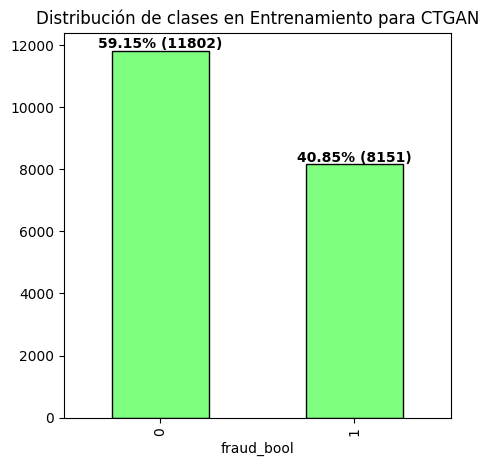

In [42]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# Graficar para el conjunto de entrenamiento
plot_class_distribution(df_train['fraud_bool'], axes, colors[0], 'Distribución de clases en Entrenamiento para CTGAN')

Se entrena el CTGAN

In [ ]:
#!pip install ctgan
from ctgan import CTGAN

In [44]:
# Entrenar el modelo
categorical_features = [col for col in df_train.columns if col not in numerical_features]
if Path(BASE_FOLDER / 'models' / 'CTGAN_model.pkl').exists():
    print("Cargando sintetizador CTGAN...")
    # Cargar el modelo en CPU
    synthesizer = joblib.load(Path(BASE_FOLDER / 'models' / 'CTGAN_model.pkl'))
    print("Sintetizador CTGAN cargado exitosamente")
else:
    print("Entrenando sintetizador CTGAN...")
    # Entrenar el modelo
    synthesizer = CTGAN(batch_size = 200, epochs = 200, verbose = True)
    synthesizer.fit(df_train, categorical_features)
    joblib.dump(synthesizer, Path(BASE_FOLDER / 'models' / 'CTGAN_model.pkl'))
    print("Sintetizador CTGAN guardado exitosamente")


Cargando sintetizador CTGAN...
Sintetizador CTGAN cargado exitosamente


Se define el ratio de aumento de datos para los fraudes

In [45]:
sample_strategy = 0.05
n_valid = X_train_scaled[y_train.flatten() == 0].shape[0]
n_fraud = X_train_scaled[y_train.flatten() == 1].shape[0]
total = n_valid + n_fraud
desired_n_fraud = int(sample_strategy * n_valid)
n_fraud_to_create = desired_n_fraud - n_fraud
print(f"Cantidad de transacciones fraudelentas a crear: {n_fraud_to_create}")

Cantidad de transacciones fraudelentas a crear: 3651


In [46]:
# Se crea el triple de datos para luego extraer el número exacto que se quiere
df_synth = synthesizer.sample(n_fraud_to_create * 4)

In [47]:
df_train.head()

income  name_email_similarity  prev_address_months_count  \
14     0.9               0.570800                          0   
37     0.8               0.098281                         29   
41     0.1               0.993219                          0   
49     0.2               0.554632                          0   
76     0.3               0.118383                         11   

    current_address_months_count  customer_age  days_since_request  \
14                           157            60            0.005908   
37                             5            20            0.000341   
41                            67            20            0.015331   
49                           112            50            0.016749   
76                            50            30            0.012838   

    intended_balcon_amount  zip_count_4w   velocity_6h  velocity_24h  ...  \
14               35.337538          4079   8139.265753   4312.230612  ...   
37                0.000000          2210   7793.630875   6258.650850  ...   
41               92.120139          1192   8330.727428   6708.346918  ...   
49                0.000000          2314  11218.081571   5284.266502  ...   
76                0.000000          1464  15211.303613   7328.054193  ...   

    housing_status_BD  housing_status_BE  housing_status_BF  \
14              False              False              False   
37              False              False              False   
41              False              False              False   
49              False              False              False   
76              False              False              False   

    housing_status_BG  source_TELEAPP  device_os_macintosh  device_os_other  \
14              False           False                False            False   
37              False           False                False            False   
41              False           False                False            False   
49              False           False                False             True   
76              False           False                False            False   

    device_os_windows  device_os_x11  fraud_bool  
14               True          False           1  
37              False          False           0  
41               True          False           1  
49              False          False           0  
76              False          False           0  

[5 rows x 46 columns]

In [48]:
df_synth.head()

income  name_email_similarity  prev_address_months_count  \
0  0.807587               0.306012                         66   
1  0.599260               0.443373                          0   
2  0.907207               0.867159                          1   
3  0.897958               0.183948                          1   
4  0.299880               0.195890                         31   

   current_address_months_count  customer_age  days_since_request  \
0                             6            30            9.581053   
1                           238            30            0.030038   
2                            49            59           -0.027224   
3                            60            50            0.043610   
4                            -6            61            0.053187   

   intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  ...  \
0                0.076453          3027  5865.698315   5806.598588  ...   
1               -0.051682           953  1588.491419   4302.883666  ...   
2                0.321536          1486  6942.927022   2101.744609  ...   
3                0.230747          1109  6941.219882   3601.290316  ...   
4               48.644202          3383  4802.848655   3908.322255  ...   

   housing_status_BD  housing_status_BE  housing_status_BF  housing_status_BG  \
0              False               True              False              False   
1              False              False              False              False   
2              False              False              False              False   
3              False              False              False              False   
4               True              False              False              False   

   source_TELEAPP  device_os_macintosh  device_os_other  device_os_windows  \
0           False                False             True              False   
1           False                False            False              False   
2           False                False            False              False   
3           False                False            False               True   
4           False                False             True              False   

   device_os_x11  fraud_bool  
0          False           0  
1          False           0  
2          False           0  
3          False           1  
4          False           0  

[5 rows x 46 columns]

In [49]:
df_synth = remove_negative_values(df_synth)
df_synth.head()

% of nulls in income: 0.0 %
% of nulls in name_email_similarity: 0.0108 %
nulls in col name_email_similarity transformed
% of nulls in prev_address_months_count: 0.0029 %
nulls in col prev_address_months_count transformed
% of nulls in current_address_months_count: 0.0474 %
nulls in col current_address_months_count transformed
% of nulls in customer_age: 0.0 %
% of nulls in days_since_request: 0.4715 %
nulls in col days_since_request transformed
% of nulls in intended_balcon_amount: 0.2082 %
nulls in col intended_balcon_amount transformed
% of nulls in zip_count_4w: 0.0038 %
nulls in col zip_count_4w transformed
% of nulls in velocity_6h: 0.001 %
nulls in col velocity_6h transformed
% of nulls in velocity_24h: 0.0 %
% of nulls in velocity_4w: 0.0 %
% of nulls in bank_branch_count_8w: 0.1847 %
nulls in col bank_branch_count_8w transformed
% of nulls in date_of_birth_distinct_emails_4w: 0.0 %
% of nulls in credit_risk_score: 0.0012 %
nulls in col credit_risk_score transformed
% of nulls 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_12836\2838181776.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][df[col]<0] = 0
C:\Users\Cristian\AppData\Local\Temp\ipykernel_12836\2838181776.py:15: SettingWithCopyWarning: 
A val

income  name_email_similarity  prev_address_months_count  \
0  0.807587               0.306012                         66   
1  0.599260               0.443373                          0   
2  0.907207               0.867159                          1   
3  0.897958               0.183948                          1   
4  0.299880               0.195890                         31   

   current_address_months_count  customer_age  days_since_request  \
0                             6            30            9.581053   
1                           238            30            0.030038   
2                            49            59            0.000000   
3                            60            50            0.043610   
4                             0            61            0.053187   

   intended_balcon_amount  zip_count_4w  velocity_6h  velocity_24h  ...  \
0                0.076453          3027  5865.698315   5806.598588  ...   
1                0.000000           953  1588.491419   4302.883666  ...   
2                0.321536          1486  6942.927022   2101.744609  ...   
3                0.230747          1109  6941.219882   3601.290316  ...   
4               48.644202          3383  4802.848655   3908.322255  ...   

   housing_status_BD  housing_status_BE  housing_status_BF  housing_status_BG  \
0              False               True              False              False   
1              False              False              False              False   
2              False              False              False              False   
3              False              False              False              False   
4               True              False              False              False   

   source_TELEAPP  device_os_macintosh  device_os_other  device_os_windows  \
0           False                False             True              False   
1           False                False            False              False   
2           False                False            False              False   
3           False                False            False               True   
4           False                False             True              False   

   device_os_x11  fraud_bool  
0          False           0  
1          False           0  
2          False           0  
3          False           1  
4          False           0  

[5 rows x 46 columns]

In [50]:
df_synth['fraud_bool'].value_counts()

fraud_bool
0    10291
1     4313
Name: count, dtype: int64

Se crea el dataframe con los fraudes sintéticos

In [51]:
df_synth_fraud = df_synth[df_synth['fraud_bool'] == 1].iloc[:n_fraud_to_create,:]

In [52]:
df_synth_fraud.shape

(3651, 46)

Se separan X e y

In [53]:
X_train_synth, y_train_synth = (df_synth_fraud.drop('fraud_bool', axis = 1),
                                df_synth_fraud['fraud_bool'])

In [54]:
X_train_aug = pd.concat([X_train, X_train_synth], axis = 0)
y_train_aug = pd.concat([y_train_serie, y_train_synth])

In [55]:
X_train_aug_scaled = scaler.transform(X_train_aug)
y_train_aug = y_train_aug.to_numpy()

In [56]:
n_valid = X_train_aug_scaled[y_train_aug == 0].shape[0]
n_fraud = y_train_aug[y_train_aug == 1].shape[0]
total = n_valid + n_fraud
print(f"Proporción de transacciones legítimas (0): {n_valid/total:.2}")
print(f"Proporción de transacciones fraudulentas (1): {n_fraud/total:.2}")

Proporción de transacciones legítimas (0): 0.95
Proporción de transacciones fraudulentas (1): 0.048


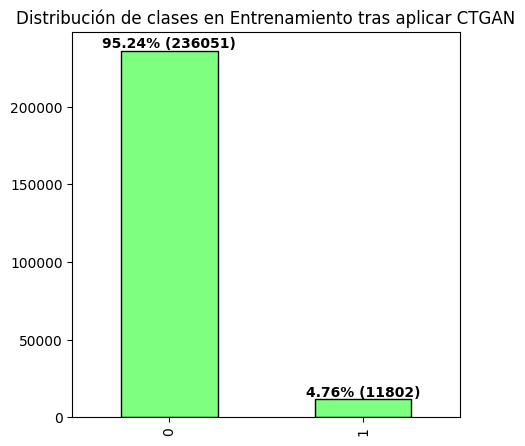

In [57]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# Graficar para el conjunto de entrenamiento
plot_class_distribution(pd.Series(y_train_aug), axes, colors[0], 'Distribución de clases en Entrenamiento tras aplicar CTGAN')

In [58]:
y_train_aug = y_train_aug.reshape(-1, 1)

#### Entrenamiento con Balanceo de clases en red neuronal y dataset mediante CTGAN

Pesos de clase: {0: 0.5249988349975218, 1: 10.500466022708016}


961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step


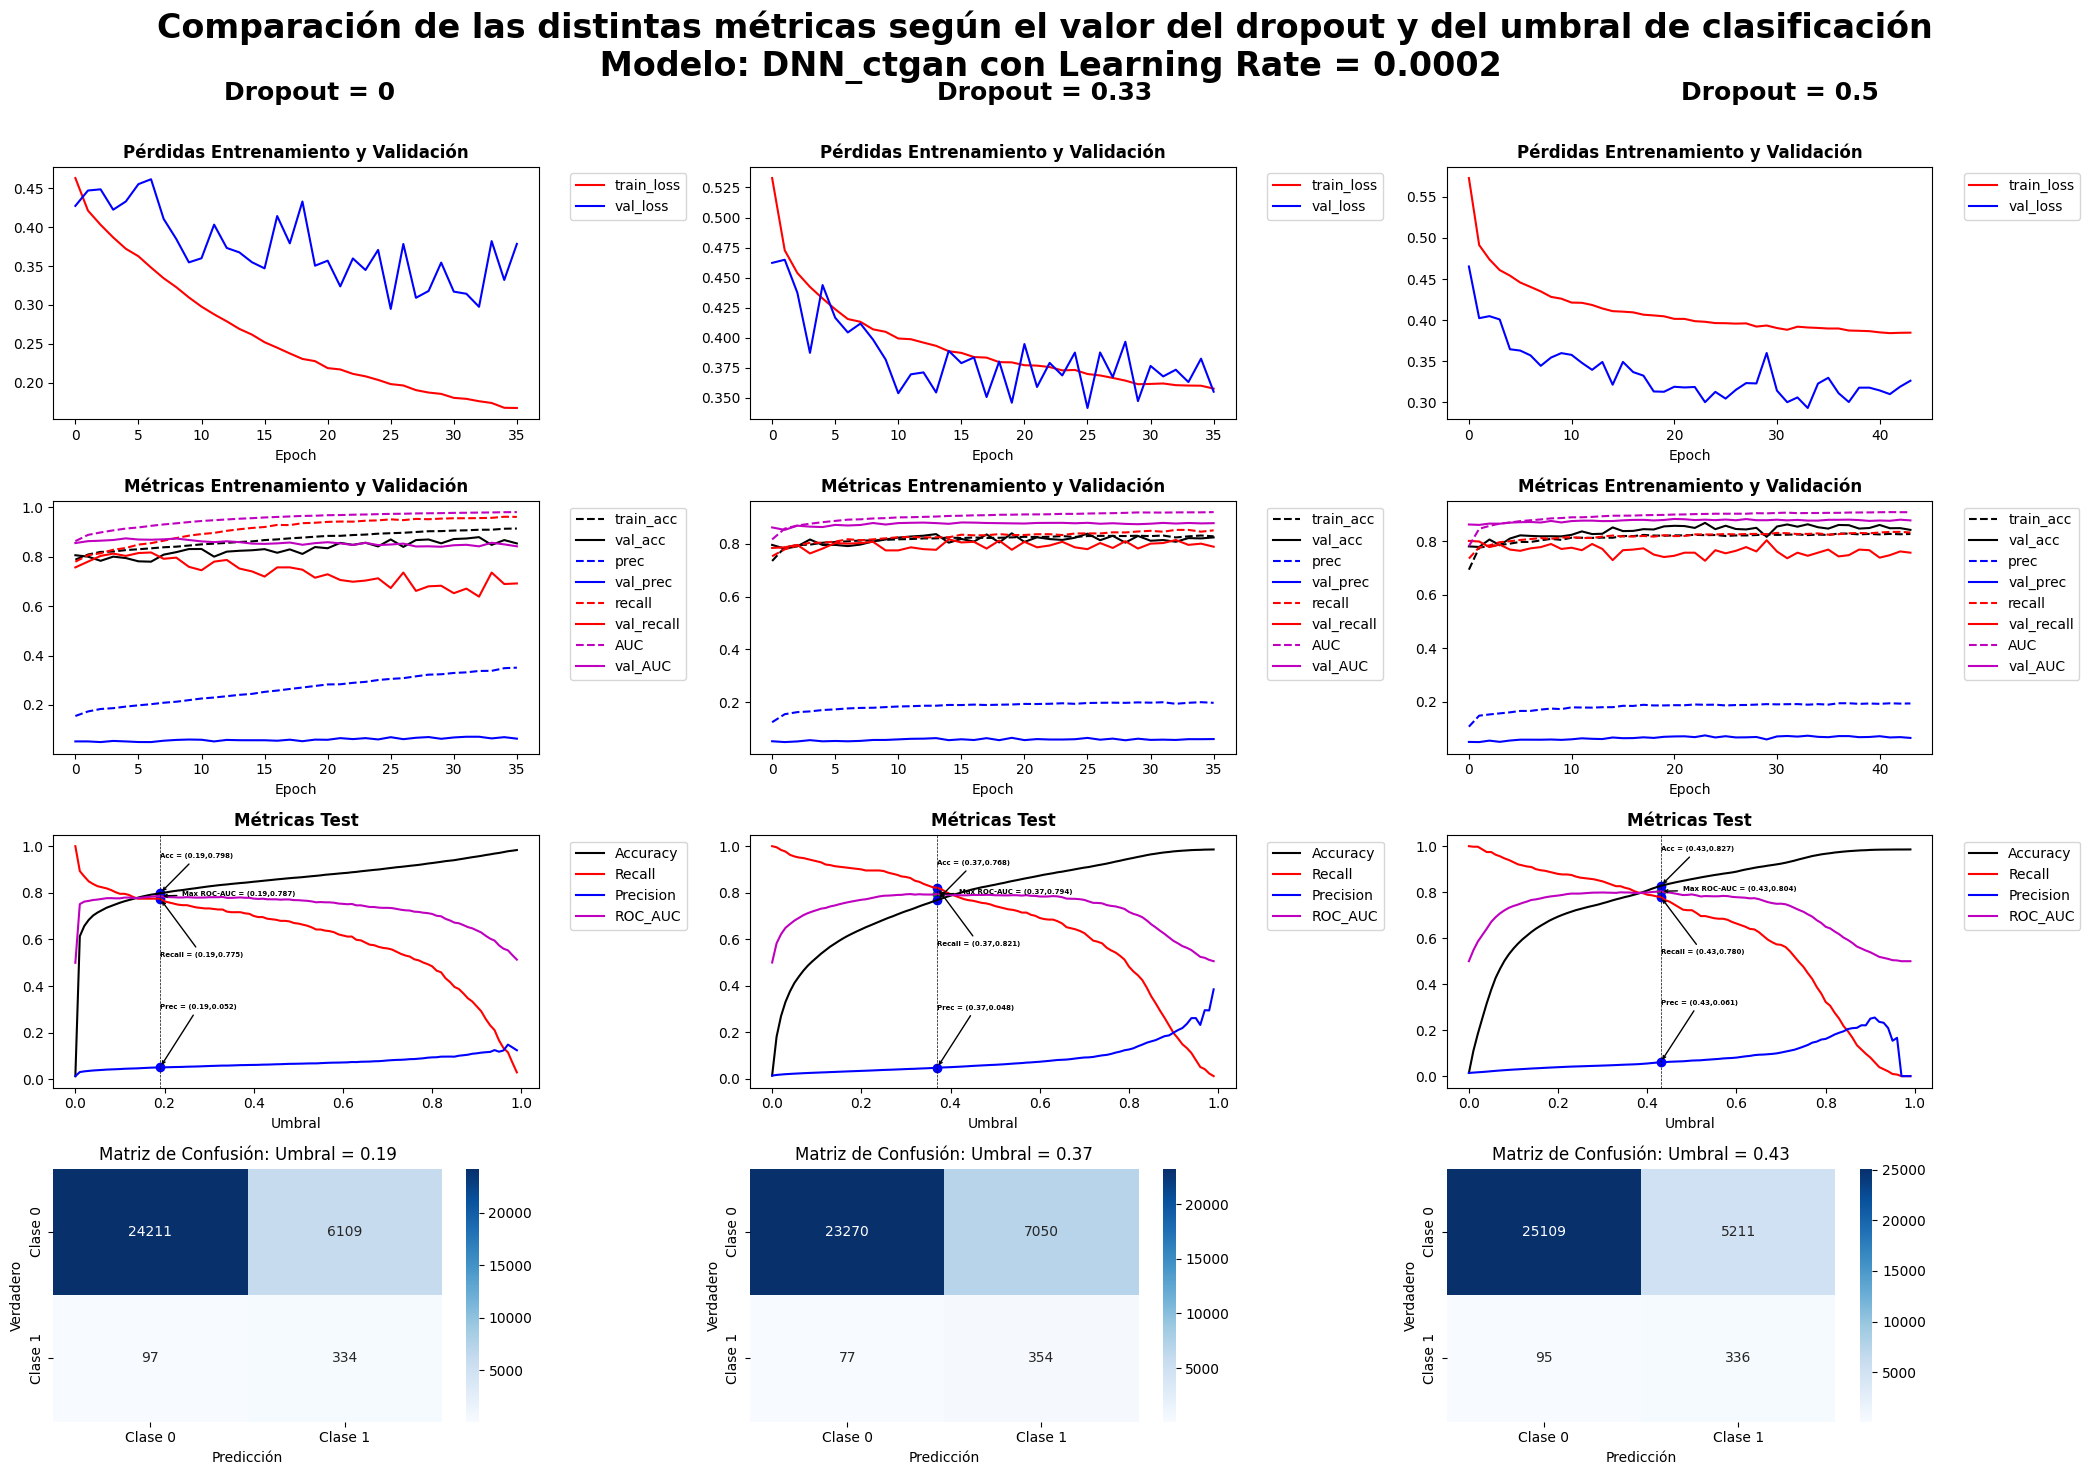

In [59]:
root_name = 'DNN_ctgan'
epochs = 50
lr = 0.0002
dnn_models, dnn_histories, dropouts = test_model(train_DNN, root_name, f'{root_name}_hist', 
                                       X_train_aug_scaled, y_train_aug, X_val_scaled, y_val, 
                                       epochs, lr, balance_class = True)
plot_fig_metrics(dnn_models, dnn_histories, X_test_scaled, y_test, dropouts, root_name, lr)

#### Balanceo de clases del dataset mediante CTGAN

In [60]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE

In [61]:
# Aplicar SMOTE solo en entrenamiento
smote = SMOTE(sampling_strategy=sample_strategy, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

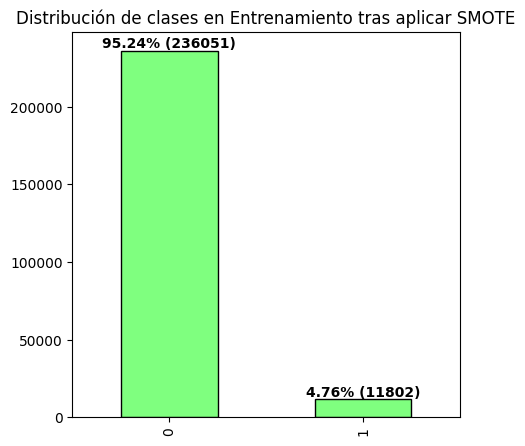

In [62]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# Graficar para el conjunto de entrenamiento
plot_class_distribution(pd.Series(y_train_smote), axes, colors[0], 'Distribución de clases en Entrenamiento tras aplicar SMOTE')

#### Entrenamiento con Balanceo de clases en red neuronal y dataset mediante SMOTE

Pesos de clase: {0: 1.0, 1: 1.0}


961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


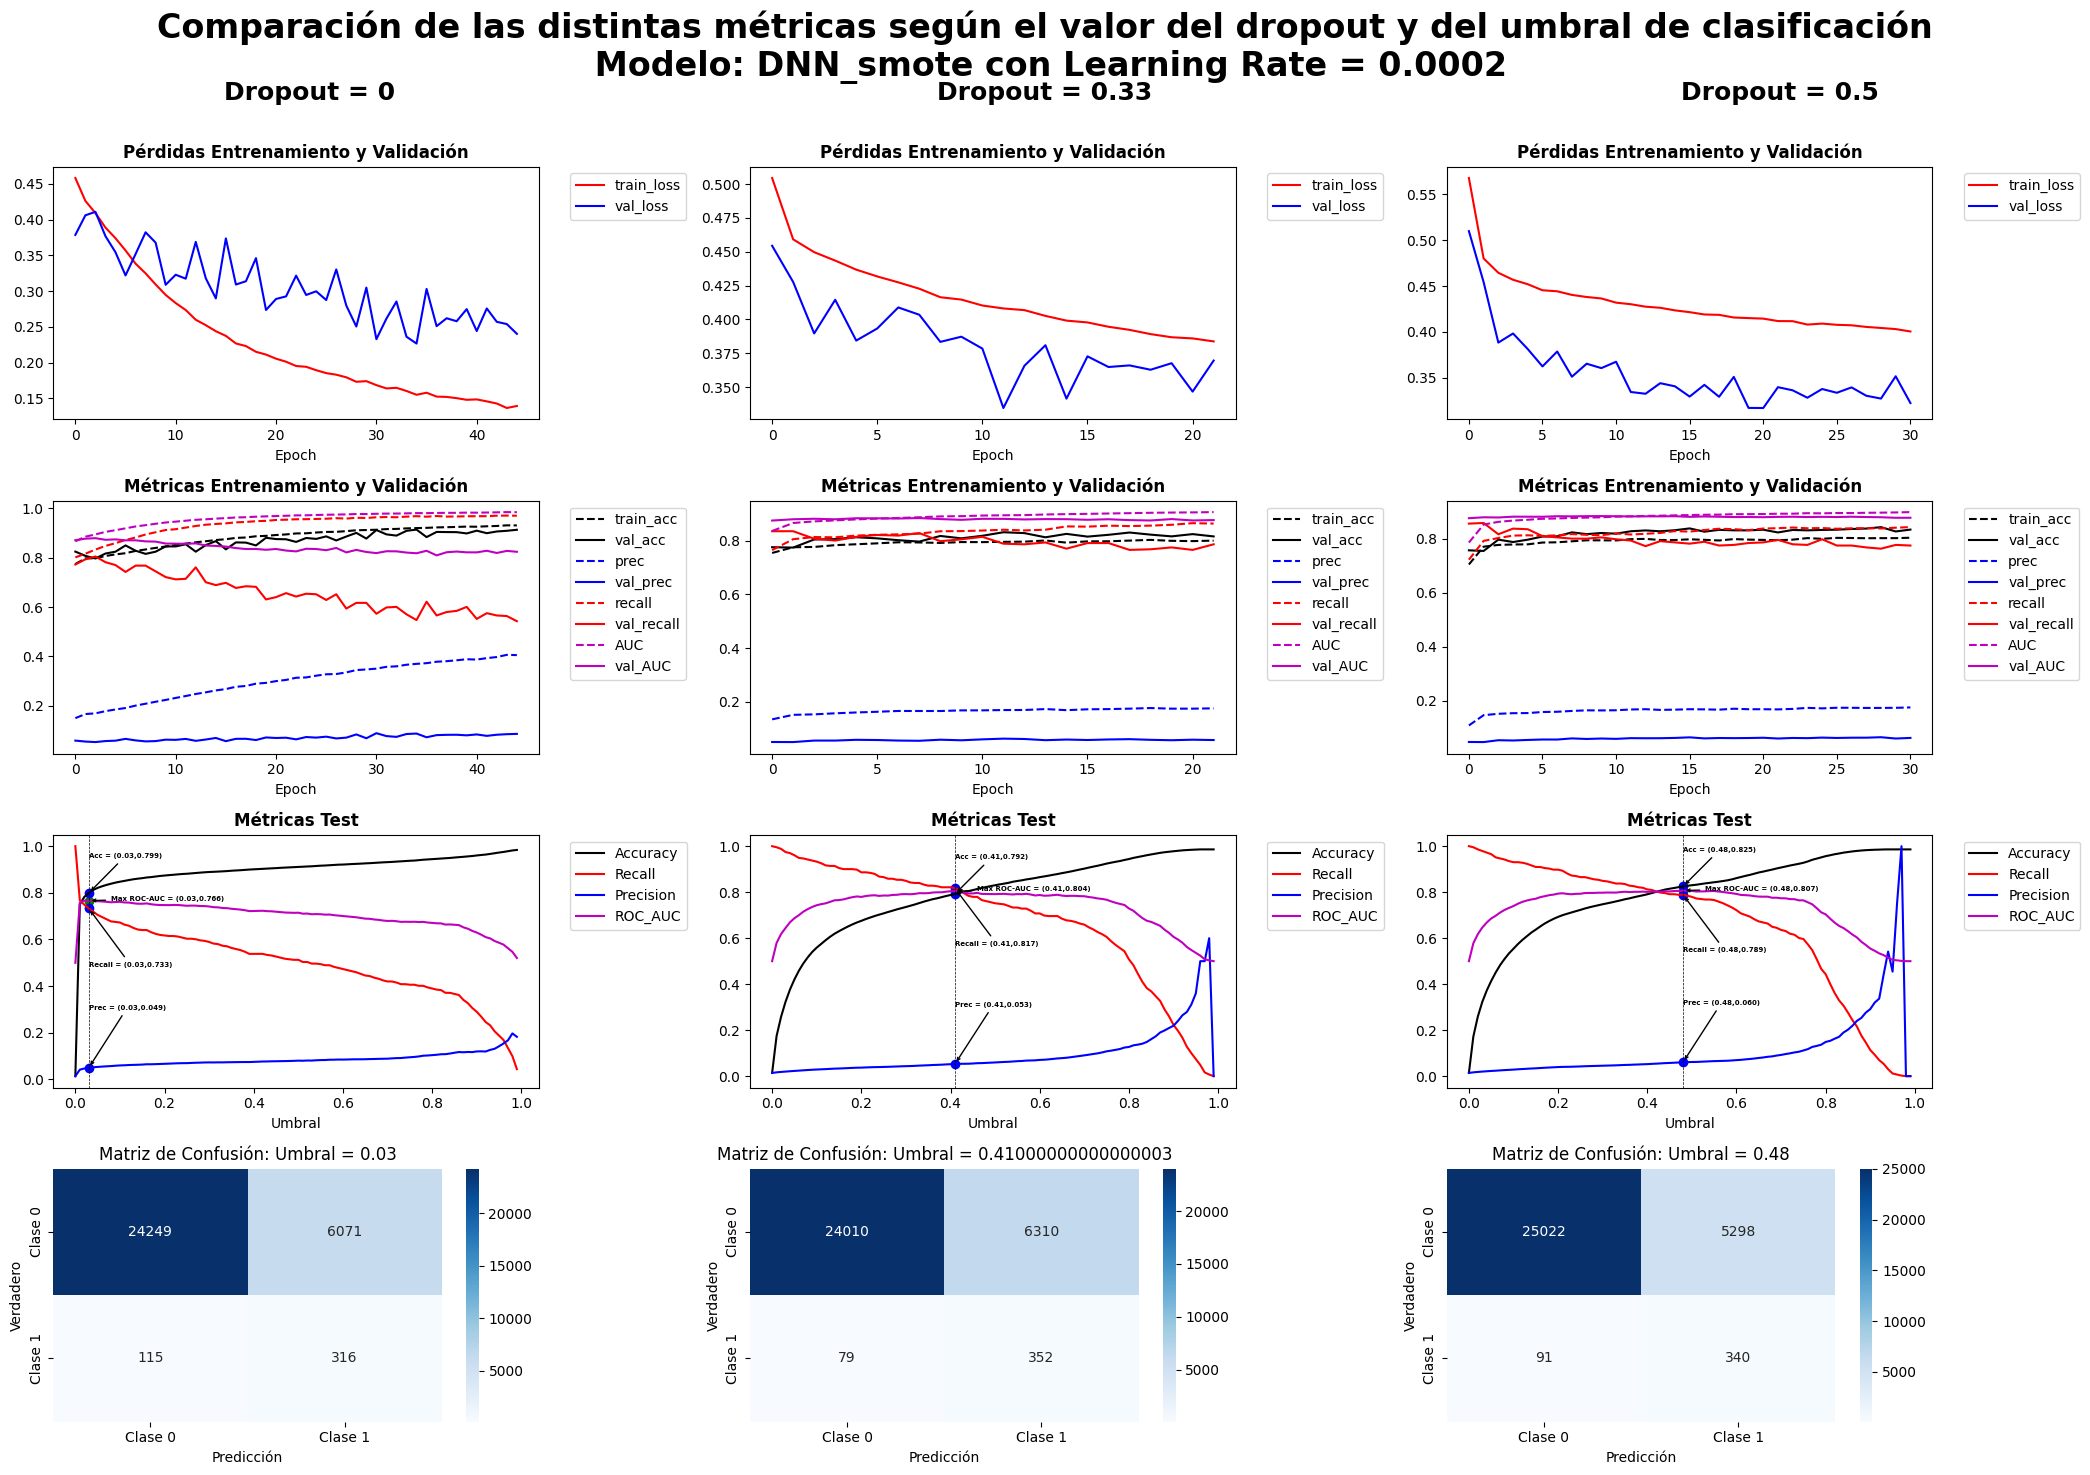

In [63]:
root_name = 'DNN_smote'
epochs = 50
lr = 0.0002
dnn_models, dnn_histories, dropouts = test_model(train_DNN, root_name, f'{root_name}_hist', 
                                       X_train_smote, y_train_smote.reshape(-1, 1), X_val_scaled, y_val, 
                                       epochs, lr, balance_class = False)
plot_fig_metrics(dnn_models, dnn_histories, X_test_scaled, y_test, dropouts, root_name, lr)

### Resultados de la DNN

De entre los *dropouts* testeados, en general, 0.5 es el valor que mejor relación muestra entre la pérdida del entrenamiento y validación. Se alcanza una estabilidad aceptable en la pérdida de validación estando por debajo de la pérdida del entrenamiento. Esto quiere decir que es la que mejor evita el sobreajuste y, por lo tanto, es la opción más robusta frente a una variación de los datos de entrada. Además, las métricas sobre entrenamiento y test (exactitud, precision y sensibilidad) se mantienen estables a medida que avanznn los epochs.

Todos los modelos presentan unas métricas de test similares con un máximo de la curva ROC-AUC en torno a 0.8 variando el umbral de un modelo a otro así como la forma de la curva. Este máximo se aproxima para todas ellas al punto de cruce entre sensibilidad y exactitud que presentan, para el mismo umbral, un valor similar. Es decir, en el umbral donde la curva ROC-AUC se hace máximo, los valores de sensibilidad y exactitud alcanzan aproximadamente el 80%. Sin embargo, la precisión en este umbral se mueve en torno al 5%.

Como la curva ROC-AUC indica la capacidad del modelo para distinguir entre las clases positivas y negativas, el umbral para el cual esta curva alcanza su máximo es un buen punto de comparación entre modelos. Por lo tanto, las siguientes valoraciones están basadas en dicho umbral (para cada modelo, el umbral donde este máximo se alcanza es diferente):

- Obsevando los resultados de los verdaderos positivos de la clase fraudulenta (clase 1) en las matrices de confusión, el mayor valor es de 359, que representa un 83% de sensibilidad. Este resultado se ha obtenido en el modelo sin ningún tipo de balanceo y con un *dropout* de 0.5. Aunque, por este resultado, pueda parecer el mejor modelo, el umbral al que se alcanzan estos valores es de 0.02, muy cercano al cero y con una curva de ROC-AUC, sensibilidad y exactitud muy acusadas. Frente a una pequeña variación de los datos de test, el umbral para este resultado podría moverse un poco causando que los resultados sean completamente diferentes (disminuyendo el umbral tan solo 0.01, la exactitud caería al 40% aproximadamente). Por lo tanto, no se considera el mejor modelo.
- El segundo modelo con el mejor resultado de verdaderos positivos de la clase fraudulenta es de 355, es decir, un 82% de sensibilidad. Este resultado se ha obtenido en el modelo con balanceo de pesos del entrenamiento de la red neuronal pero sin balanceo de clases en el dataset y con un *dropout* de 0.5. A diferencia del anterior, las curvas de las métricas son mucho más suaves demostrando ser un modelo más robusto frente a variaciones de los datos de test siendo el umbral igual a 0.43.
- Poniendo el foco en el máximo valor de la curva ROC-AUC, precisamente el modelo mencionado es el que presenta el mayor valor de todos los modelos: 0.811.

Por lo tanto, para la creación de la CNN no se usará el balanceo de clases en el dataset pero sí se usará el balanceo de pesos en el entrenamiento.



## Red Neuronal Convolucional (CNN)

### De Vector unidimensional a Imagen RGB

In [64]:
def transform_to_imgs(arr):
    #Se crea un arreglo de numpy con forma (i, j, j), como un arreglo de imágenes
    i = arr.shape[0]
    j = arr.shape[1]

    new_arr1 = np.zeros((i, j, j))
    new_arr2 = np.zeros((i, j, j))
    new_arr3 = np.zeros((i, j, j))
    new_arrays = (new_arr1, new_arr2, new_arr3)
    # Ahora, tanto para los arreglos de entrenamiento como validación, así como los validos y fraudulentos, se rellena la diagonal principal con sus valores de vector
    for k in range(i):
        for new_arr in new_arrays:
          np.fill_diagonal(new_arr[k], arr[k])

    # Se rellena fuera de la diagonal con las medias aritméticas
    for k in range(i):
        for row in range(j):
            for col in range(row + 1, j):  # Solo iterar la parte superior
                #Se realiza la operación de la media aritmética
                value1 = arr[k, row]
                value2 = arr[k, col]
                # Operaciones
                avg = np.mean((value1, value2))
                diff = abs(value1 - value2)
                prod = np.prod((value1, value2))
                #Se reemplazan los valores
                new_arrays[0][k, row, col] = avg
                new_arrays[0][k, col, row] = avg
                new_arrays[1][k, row, col] = diff
                new_arrays[1][k, col, row] = diff
                new_arrays[2][k, row, col] = prod
                new_arrays[2][k, col, row] = prod

    # Apilar los arrays en el eje del canal
    img_array = np.stack((new_arrays[0], new_arrays[1], new_arrays[2]), axis=-1)
    return img_array

Las redes neuronales convolucionales (CNN, por sus siglas en inglés) son un tipo de arquitectura de redes neuronales especialmente diseñada para procesar datos con estructura espacial, como imágenes. A diferencia de las redes densas, que conectan todas las neuronas entre capas, las CNN utilizan operaciones de convolución para extraer características locales y jerárquicas, lo que las hace más eficientes en términos de parámetros y computación. Esta capacidad les permite capturar patrones como bordes, texturas y formas, lo que las convierte en una herramienta poderosa para tareas de visión por computadora, como clasificación de imágenes, detección de objetos y segmentación. Además, su diseño las hace menos propensas al sobreajuste en comparación con las redes densas, especialmente cuando se trabaja con datos de alta dimensionalidad.

El uso de redes neuronales convolucionales (CNN) como alternativa a una red neuronal densa (DNN) para la clasificación binaria de transacciones fraudulentas o legítimas en el ámbito bancario se justifica por su capacidad para capturar relaciones complejas y patrones no lineales en los datos, especialmente cuando estos se transforman en una representación visual. La idea principal consiste en convertir cada instancia tabular del dataset en una imagen de tres canales RGB, lo que permite aprovechar la potencia de las CNN para extraer características espaciales y jerárquicas que podrían pasar desapercibidas en una DNN.

En este enfoque, cada transacción se representa como un vector unidimensional escalado entre 0 y 1, que se transforma en una matriz cuadrada de tamaño *y x y*, donde *y* es el número de características. La diagonal principal de la matriz se llena con los valores del vector, mientras que los triángulos superior e inferior se completan de manera simétrica utilizando operaciones matemáticas entre pares de características. Esta simetría garantiza que la estructura de la matriz sea coherente y aproveche las relaciones entre las características. Al tratarse de una imagen RGB, se generan tres matrices (canales) por transacción: 
1. **Canal 1**: Se calcula la media de cada par de características, lo que proporciona información sobre la tendencia central de las relaciones entre ellas.
2. **Canal 2**: Se utiliza la diferencia entre cada par de características, lo que resalta las disparidades o contrastes entre ellas.
3. **Canal 3**: Se calcula el producto de cada par de características, lo que enfatiza las interacciones multiplicativas entre ellas.

De esta manera, se obtiene una representación tridimensional de cada transacción en forma de una matriz de dimensiones (*x, y, y, c*), donde *x* es el número de instancias, *y* es el número de características y *c* es el número de canales (3 en este caso). Esta transformación permite a la CNN analizar las transacciones como si fueran imágenes, capturando patrones locales y globales que podrían ser críticos para identificar fraudes. Además, al utilizar operaciones matemáticas específicas para generar los canales, se enriquece la información disponible para el modelo, lo que puede mejorar su capacidad de discriminación entre transacciones fraudulentas y legítimas. Este enfoque es especialmente útil cuando las relaciones entre características no son evidentes en el formato tabular tradicional, pero pueden ser explotadas eficientemente mediante convoluciones en el espacio de la imagen.

Además de mejorar el rendimiento en la clasificación de transacciones fraudulentas, el enfoque de transformar datos tabulares en imágenes para su procesamiento con redes neuronales convolucionales (CNN) ofrece ventajas únicas que no son factibles con redes neuronales densas (DNN). Una de estas aplicaciones es la anonimización de datos mediante la codificación en imágenes, lo que permite preservar la privacidad de la información sensible mientras se mantiene la utilidad para el análisis. Al convertir las transacciones en imágenes, los datos originales (como nombres, números de cuenta o identificadores personales) pueden ser ofuscados o eliminados, ya que la representación visual no requiere conservar la estructura tabular original. Esto es especialmente útil en entornos donde la privacidad es crítica, como en el sector bancario o financiero.

Otra aplicación interesante es la integración con sistemas de visión por computadora existentes. Una vez que las transacciones se codifican como imágenes, pueden ser procesadas por sistemas diseñados para analizar imágenes, como escáneres o herramientas de procesamiento visual. Por ejemplo, las transacciones podrían ser "escaneadas" o analizadas mediante técnicas de visión artificial, lo que permitiría su clasificación o detección de anomalías utilizando infraestructura ya desplegada para otros fines, como la inspección de documentos o la verificación de firmas. Esto no sería posible con una DNN, ya que estas redes no están diseñadas para trabajar directamente con datos visuales.

Además, la representación en imágenes permite la compresión eficiente de datos. Las técnicas de compresión de imágenes, como JPEG o PNG, pueden aplicarse a las matrices generadas, reduciendo el tamaño de los datos sin perder información crítica. Esto es especialmente útil cuando se trabaja con grandes volúmenes de transacciones, ya que facilita el almacenamiento y la transmisión de datos.

Por último, este enfoque permite la interpretación visual de los datos. Las imágenes generadas pueden ser inspeccionadas visualmente por expertos para identificar patrones o anomalías, lo que no es posible con una DNN que opera directamente sobre datos tabulares. Esto abre la puerta a un análisis híbrido, donde tanto el modelo de CNN como los expertos humanos pueden colaborar para mejorar la detección de fraudes.

En resumen, la transformación de datos tabulares en imágenes no solo mejora el rendimiento del modelo, sino que también habilita aplicaciones únicas como la anonimización de datos, la integración con sistemas de visión por computadora, la compresión eficiente y la interpretación visual, ventajas que no son alcanzables con redes neuronales densas tradicionales.


Transformación de formato tabular a instancias de imágenes

In [65]:
arr_data = (X_train_scaled, X_val_scaled, X_test_scaled)
imgs_data_names = ('X_train_img.npy', 'X_val_img.npy', 'X_test_img.npy')
arr_names = zip(arr_data, imgs_data_names)
for arr, name in arr_names:
  if not os.path.exists(Path(BASE_FOLDER / 'numpy_images' / name)):
    print(f"Generando array de imágenes para {name} a partir de vectores unidimensionales...")
    imgs = transform_to_imgs(arr)
    # Guardar el arreglo en un archivo .npy
    print(f"Guardando {name}...")
    np.save(BASE_FOLDER / 'numpy_images' / name, imgs)
    print(f"{name} guardado exitosamente.")
print("Cargando imágenes...")
X_train_img, X_val_img, X_test_img = (np.load(BASE_FOLDER / 'numpy_images' / imgs_data_names[0]),
                                      np.load(BASE_FOLDER / 'numpy_images' / imgs_data_names[1]),
                                      np.load(BASE_FOLDER / 'numpy_images' / imgs_data_names[2]))
print("Imágenes cargadas correctamente")


Cargando imágenes...
Imágenes cargadas correctamente


Visualización de imágenes de transacciones

In [66]:
X_train_img.shape

(244202, 45, 45, 3)

In [67]:
#Se crean arrays de train divididos por clase con el fin de visualizarlos de forma distinguida
X_train_img_valid = X_train_img[y_train.flatten() == 0]
X_train_img_fraud = X_train_img[y_train.flatten() == 1]

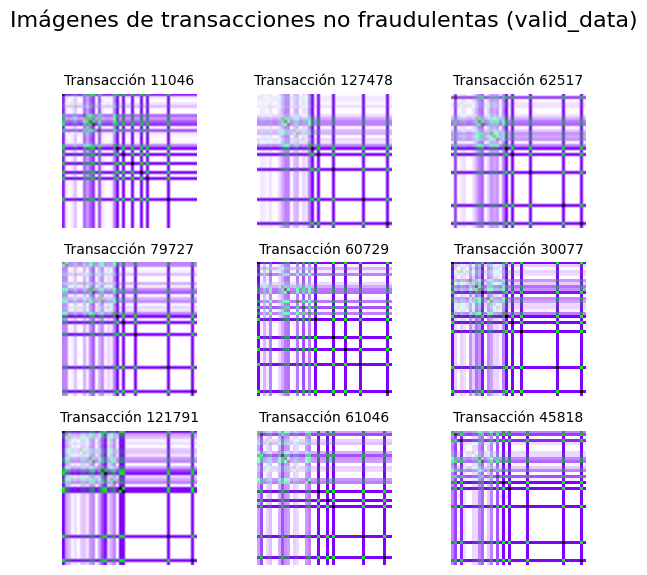

In [68]:
# Se crean arrays con
#Se seleccionan 9 imágenes aleatorias
random_indexes = np.random.choice(X_train_img_valid.shape[0], size = 9, replace = False)
imgs_sel = X_train_img_valid[random_indexes]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

#Se añade un título al a figura
fig.suptitle("Imágenes de transacciones no fraudulentas (valid_data)", fontsize=16, y=0.95)

# Recorrer cada imagen seleccionada y mostrarla
for i, ax in enumerate(axes.flat):
    ax.imshow(1- imgs_sel[i])  # Mostrar en colores invertidos
    ax.axis("off")  # Ocultar ejes
    ax.set_title(f"Transacción {random_indexes[i]}", fontsize=10)  # Título para cada imagen

# Ajustar el espacio entre imágenes
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

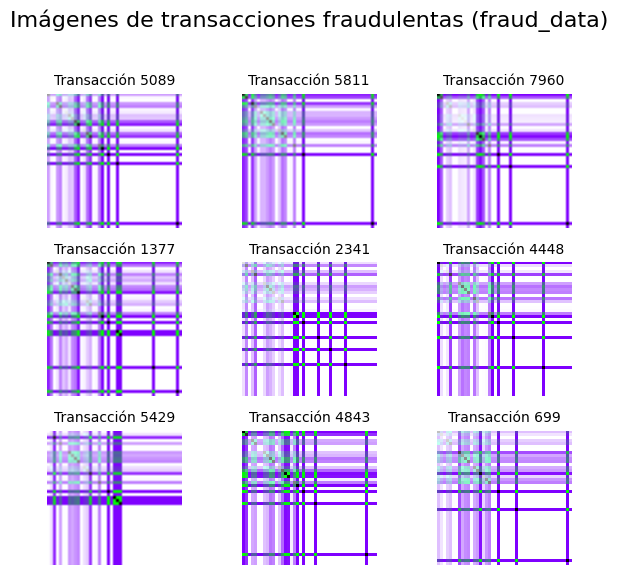

In [69]:
#Se seleccionan 9 imágenes aleatorias
random_indexes = np.random.choice(X_train_img_fraud.shape[0], size = 9, replace = False)
imgs_sel = X_train_img_fraud[random_indexes]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

#Se añade un título al a figura
fig.suptitle("Imágenes de transacciones fraudulentas (fraud_data)", fontsize=16, y=0.95)

# Recorrer cada imagen seleccionada y mostrarla
for i, ax in enumerate(axes.flat):
    ax.imshow(1- imgs_sel[i])
    ax.axis("off")  # Ocultar ejes
    ax.set_title(f"Transacción {random_indexes[i]}", fontsize=10)  # Título para cada imagen

# Ajustar el espacio entre imágenes
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

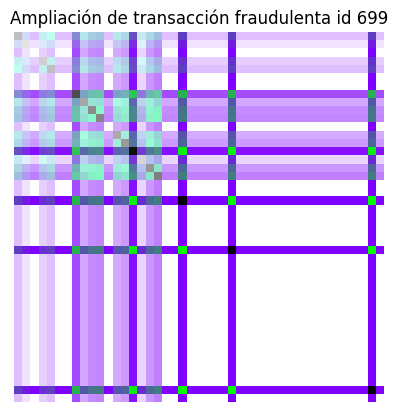

In [70]:
plt.imshow(1- X_train_img_fraud[699])
plt.axis('off')
plt.title(f"Ampliación de transacción fraudulenta id 699")
plt.show()

### Desarrollo de la arquitectura de la CNN

Para la creación de la CNN, se va a utilizar una arquitectura típica como la que se muestra en la siguiente figura:

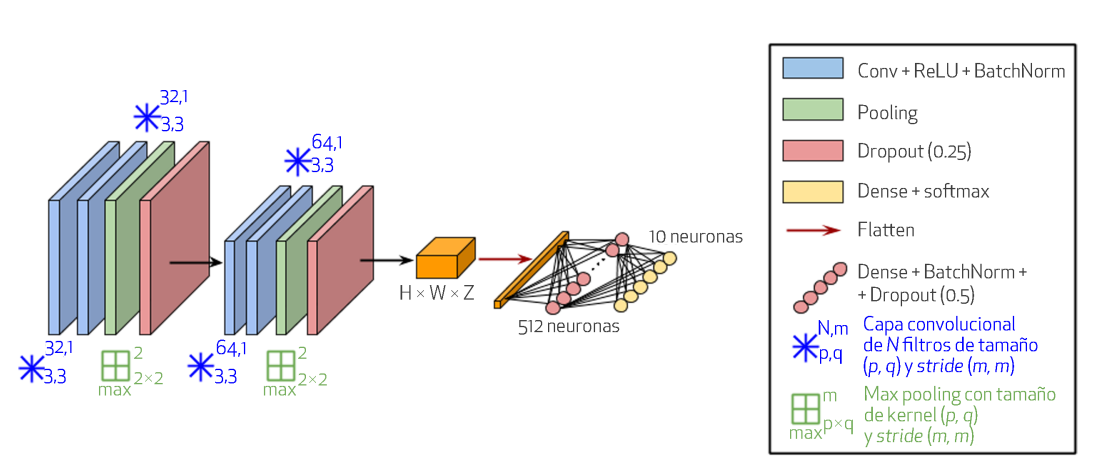

El bloque típico de una red convolucional consta de tres etapas. La primera capa de las que se compone el bloque realiza varias convoluciones en paralelo (mediante un determinado número de filtros o kernels) para producir un conjunto de activaciones lineales. En la segunda etapa, cada activación de salida de la operación convolución es la entrada a una función de activación no lineal, como la función de activación ReLU. En la tercera etapa, empleamos una capa de pooling para modificar aún más la salida del
bloque convolucional (Adrán C. & Gabriel M., s.f., Figura 18. Arquitectura de red neuronal convolucional típica. En este caso se trata de una CNN compuesta por dos bloques convolucionales).

Además, cada bloque contiene una última capa de **DropOut**, usada para la desactivación aleatoria de un porcentaje de neuronas y así evitar el sobreaprendizaje.

Con el fin de normalizar los datos al final de cada salida de capa convolucional, se incluirá la normalización **BatchNormalization()**. Esta normalización repecutirá en una mayor eficiencia del rendimiento y dará estabilidad al aprendizaje.

Tras todos estos bloques, se encuentra una red densa que tiene la misión de aprender de todos los patrones extraidos de las características de las capas convolucionales anteriores.

Por último, una última capa de tantas neuronas como clases se tiene (12) será añadida de salida con la función de activación **softmax**, que dará una probabilidad por cada clase.

Esta última capa es la que el modelo utiliza para predecir.

Se utilizarán 50 épocas de entrenamiento con un batch size de 128. El optimizador será *Adam*.



In [71]:
def train_CNN(X_train_img, y_train, X_val_img, y_val, epochs, lr, dropout, class_weight_dict):
  #Se calcula la resolución de la imagen
  resol = X_train_img.shape[1]
  chanels = X_train_img.shape[3]
  #########################################
  ###### Definimos la arquitectura ########
  #########################################
  #BASE MODEL
  # Definimos entradas
  inputs = Input(shape = (resol, resol, chanels))

  #Se define el primer set de capas de la arquitectura
  x1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(inputs)
  x1 = BatchNormalization()(x1)
  x1 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x1)
  x1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size = (2, 2))(x1)
  x1 = Dropout(dropout)(x1)

  x2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x1)
  x2 = BatchNormalization()(x2)
  x2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x2)
  x2 = BatchNormalization()(x2)
  x2 = MaxPooling2D(2, 2)(x2)
  x2 = Dropout(dropout)(x2)

  x3 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x2)
  x3 = BatchNormalization()(x3)
  x3 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x3)
  x3 = BatchNormalization()(x3)
  x3 = MaxPooling2D(pool_size = (2, 2))(x3)
  x3 = Dropout(dropout)(x3)

  #Red densa
  xfc = Flatten()(x3)
  xfc = Dense(512, activation = 'relu')(xfc)
  xfc = BatchNormalization()(xfc)
  xfc = Dropout(dropout)(xfc)
  xfc = Dense(256, activation = 'relu')(xfc)
  xfc = BatchNormalization()(xfc)
  xfc = Dropout(dropout)(xfc)
  xfc = Dense(128, activation = 'relu')(xfc)
  xfc = BatchNormalization()(xfc)
  xfc = Dropout(dropout)(xfc)

  #Salida
  output = Dense(1, activation = 'sigmoid')(xfc)

  #Se une el modelo de inicio a fin
  cnn_model = Model(inputs = inputs, outputs = output, name = 'deepCNN_fraud_transaction')

  #Se imprime el modelo
  cnn_model.summary()

  #Se compila el modelo
  cnn_model.compile(loss = 'binary_crossentropy',
                    optimizer = Adam(lr),
                    metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall'), F1Score(name = 'f1'), AUC(name="AUC")])
  # Entrenamiento de la red
  print("[INFO]: Entrenando la red...")
  with tf.device('/GPU:0'): #Especifico que use la GPU
    # Entrenar el modelo con pesos de clase
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    H = cnn_model.fit(X_train_img, y_train,
                      batch_size=512, epochs = epochs, verbose=1,
                      validation_data = (X_val_img, y_val), shuffle = True,
                      class_weight = class_weight_dict,
                      callbacks = [early_stop])
  return cnn_model, H

### CNN Tests

#### Entrenamiento con Balanceo de clases en CNN

Pesos de clase: {0: 0.51726533672808, 1: 14.979879769353454}


961/961 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

961/961 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Cristian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

961/961 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


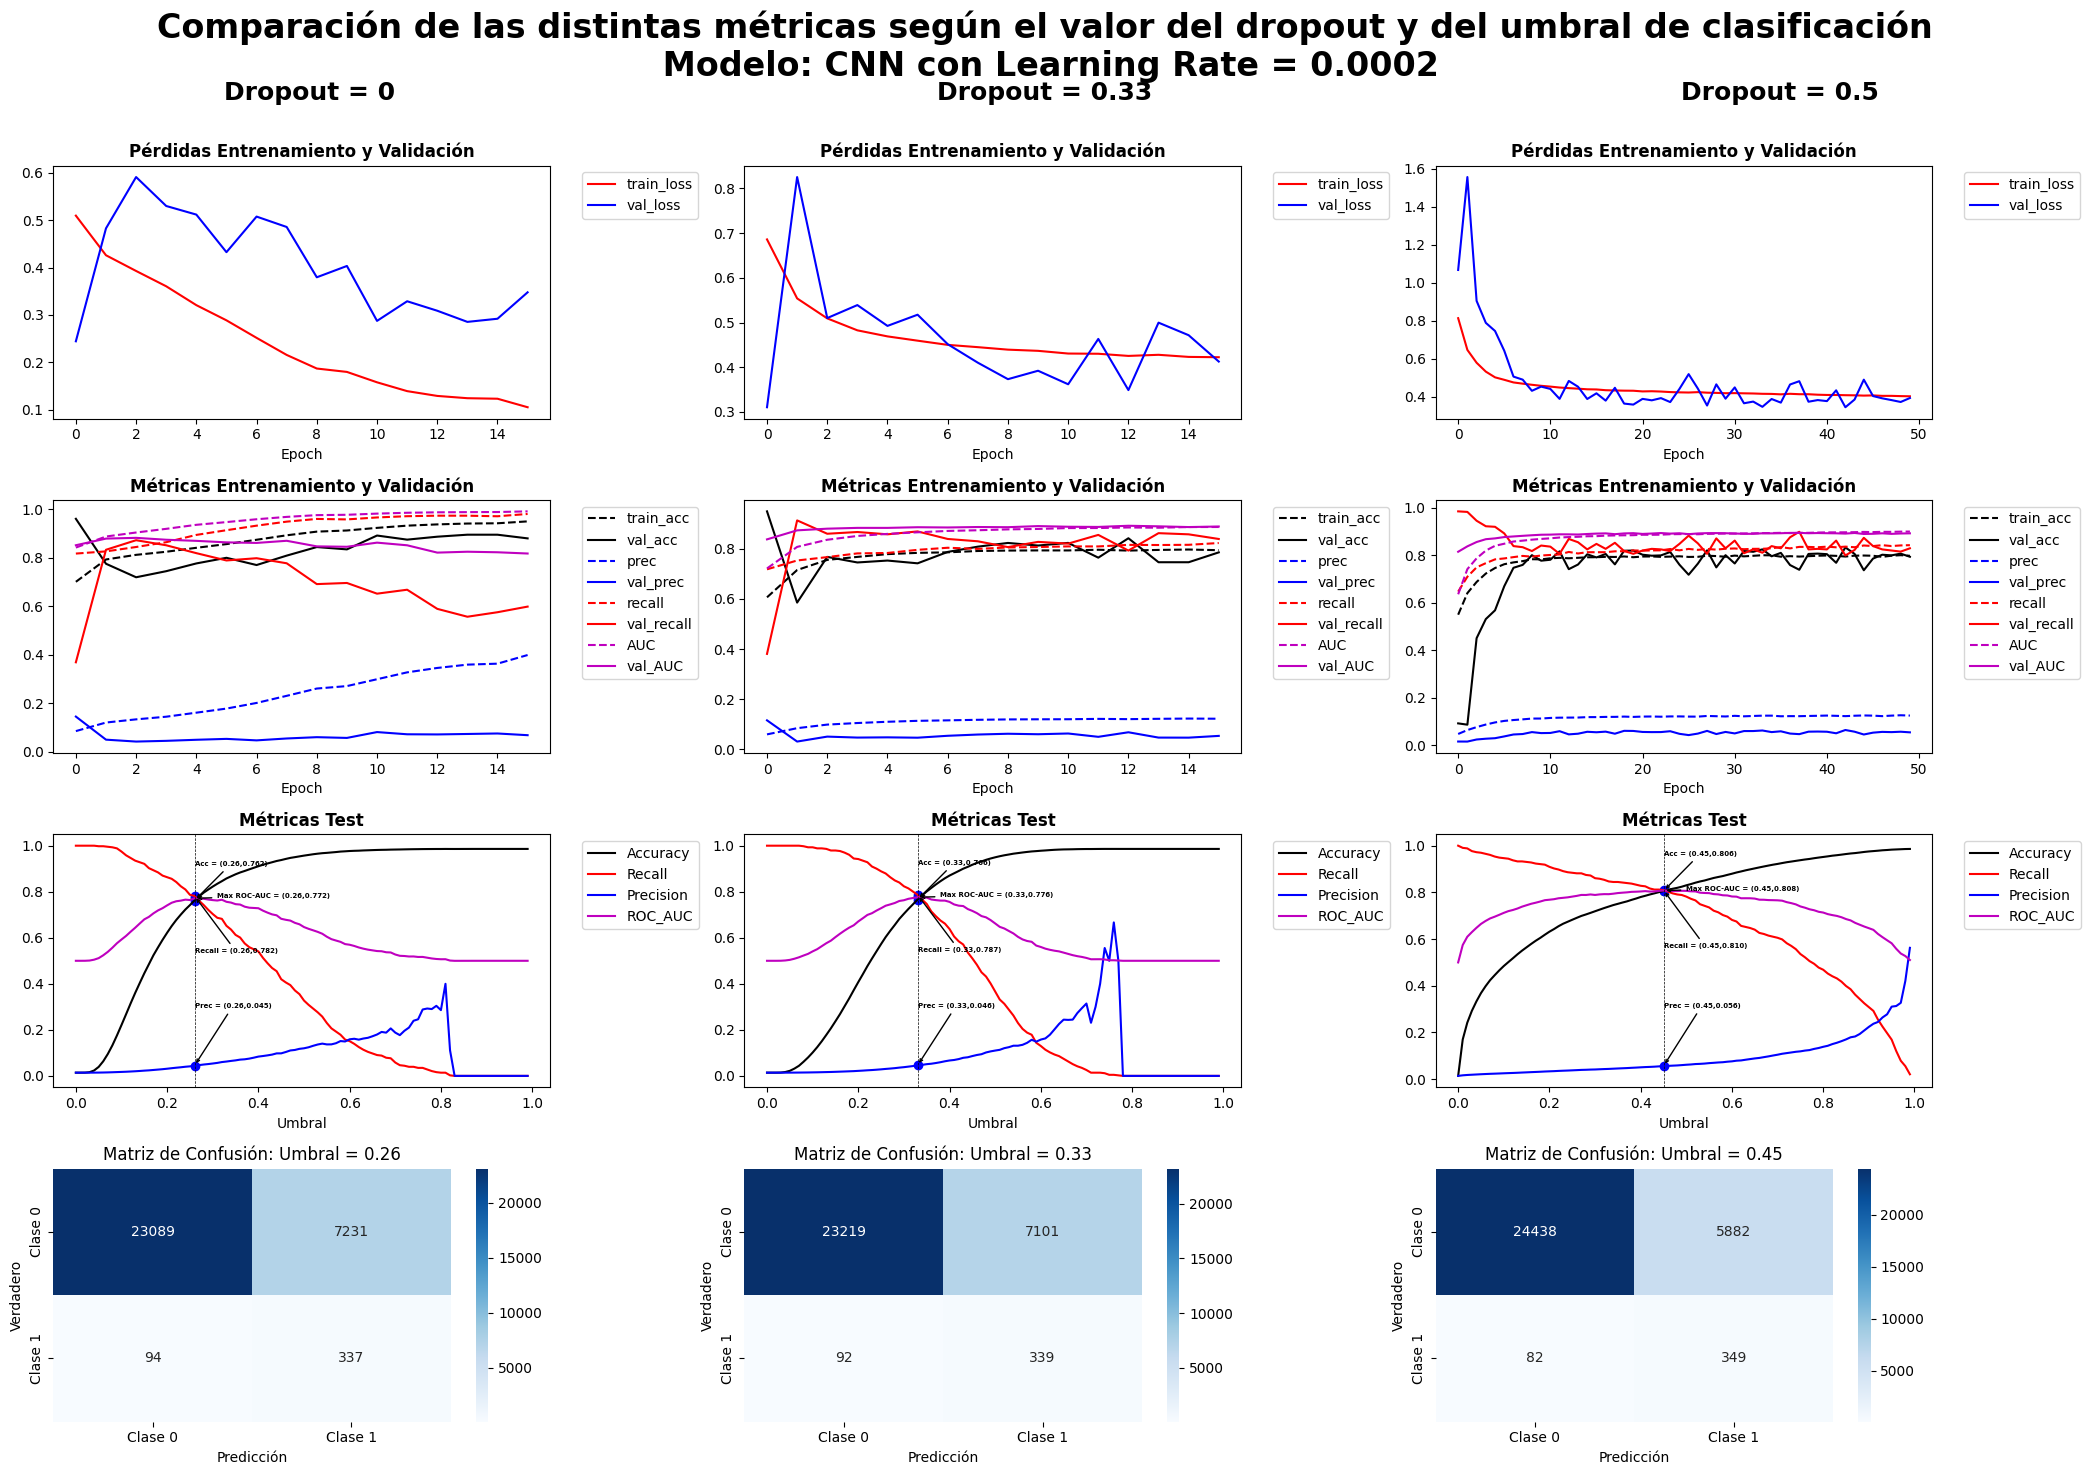

In [72]:
root_name = 'CNN'
epochs = 50
lr = 0.0002
cnn_models, cnn_histories, dropouts = test_model(train_CNN, root_name, f'{root_name}_hist', 
                                       X_train_img, y_train.reshape(-1, 1), X_val_img, y_val, 
                                       epochs, lr, balance_class = True)
plot_fig_metrics(cnn_models, cnn_histories, X_test_img, y_test, dropouts, root_name, lr)

### Resultados de la CNN

## Modelo Combinado: DNN + CNN

In [73]:
from tensorflow.keras.layers import Concatenate

In [74]:
# Se cargan los modelos preentrenados
cnn_model = load_model(Path(BASE_FOLDER / 'models' / 'CNN_dropout-0.5_lr-0.0002.h5'))
dnn_model = load_model(Path(BASE_FOLDER / 'models' / 'DNN_class_bal_dropout-0.5_lr-0.0002.h5'))

# Se extraen las capas relevantes (sin la salida original)
dnn_feature_extractor = Model(inputs=dnn_model.layers[0].input, outputs=dnn_model.layers[-2].output)  # Penúltima capa
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)  

# Se definen nuevas entradas
input_dnn = Input(shape=dnn_model.layers[0].input.shape[1:])  
input_cnn = Input(shape=cnn_model.input.shape[1:])

# Se obtienen salidas intermedias
dnn_features = dnn_feature_extractor(input_dnn)
cnn_features = cnn_feature_extractor(input_cnn)

# Se fusionan las características
merged = Concatenate()([dnn_features, cnn_features])

# Se agregan capas finales para la salida común
output = Dense(1, activation="sigmoid")(merged)

# Se crea el modelo fusionado
combined_model = Model(inputs=[input_dnn, input_cnn], outputs=output)

# Se compila el modelo
combined_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

961/961 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
961/961 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step
961/961 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


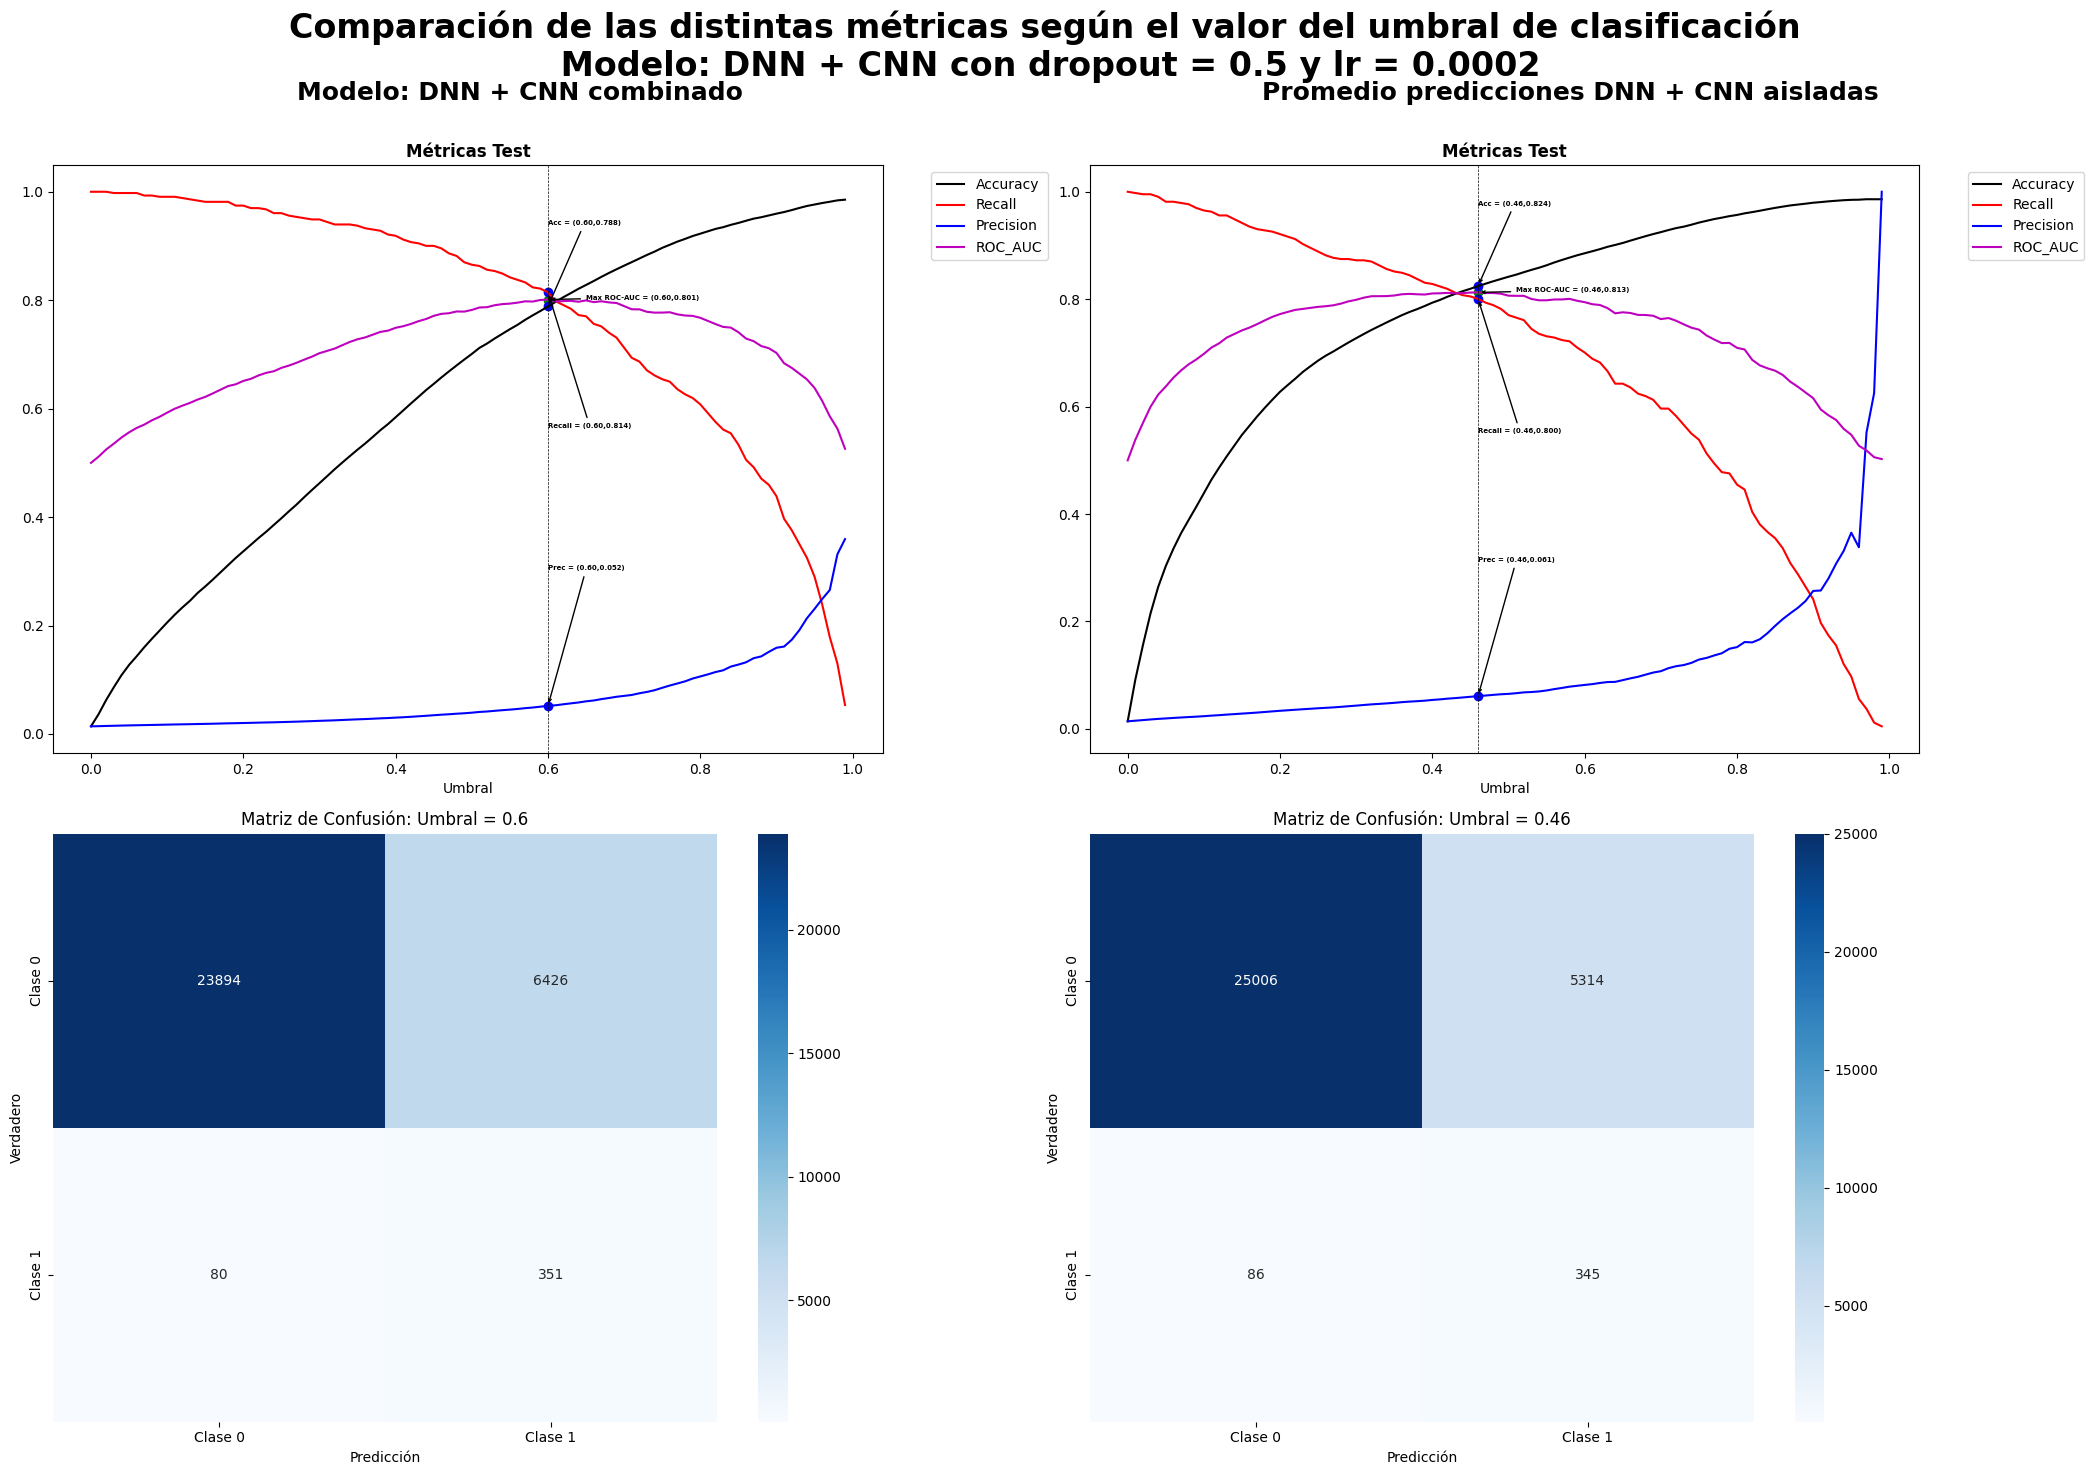

In [75]:
# Se realizan las predicciones del modelo combinado
y_pred_prob_comb = combined_model.predict([X_test_scaled, X_test_img])

# Se realizan las predicciones del modelo combinado
y_pred_prob_dnn = dnn_model.predict(X_test_scaled)
y_pred_prob_cnn = cnn_model.predict(X_test_img)
y_pred_prob_mean = np.mean([y_pred_prob_dnn, y_pred_prob_cnn], axis=0)

preds = (y_pred_prob_comb, y_pred_prob_mean)
# Se crea la figura para plotear
fig, axs = plt.subplots(2, 2, figsize = (21, 15))
axs = axs.flatten()
for i, pred in enumerate(preds):
  # Se plotean las métricas de test
  _, opt_threshold = plot_metrics(pred, y_test, ax=axs[i])
  plot_cm(pred, y_test, ax=axs[i+2], threshold = opt_threshold)

# Se agrega un título general a la figura
fig.suptitle(f'Comparación de las distintas métricas según el valor del umbral de clasificación\n Modelo: DNN + CNN con dropout = 0.5 y lr = 0.0002',
              fontsize = 24, fontweight = 'bold')

# Se agrega títulos a las columnas
fig.text(0.25, 0.92, f"Modelo: DNN + CNN combinado", ha='center', fontsize=18, fontweight='bold')
fig.text(0.75, 0.92, f"Promedio predicciones DNN + CNN aisladas", ha='center', fontsize=18, fontweight='bold')


fig.tight_layout(rect=[0, 0, 1, 0.96])
file_name = 'DNN_CNN_dropout-0.5_lr-0.0002_metrics.png'
plt.savefig(Path(BASE_FOLDER / 'figs' / file_name))
plt.show()  # Mostrar todas las gráficas juntas

Referencias:

- Jesus, S., Pombal, J., Alves, D., Cruz, A. F., Saleiro, P., Ribeiro, R. P., Gama, J., & Bizarro, P. (s. f.). BAF Dataset Suite Datasheet.
- Adrián Colomer Granero y Gabriel Enrique Muñoz Ríos (s. f.). Universidad Internacional de Valencia. *REDES NEURONALES Y APRENDIZAJE PROFUNDO*. 